In [2]:
%matplotlib inline
import os
import sys
import numpy as np
import scipy as sp
import scipy.optimize
import matplotlib as mpl
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib import rc
import pdb
import h5py
import subprocess
import datetime

import platform
if platform.system() == 'Darwin':
    # On a Mac: usetex ok
    mpl.rc('font',**{'family':'serif','serif':['Computer Modern']})
    mpl.rcParams['font.size'] = 25.0
    mpl.rc('text', usetex=True)
elif platform.node().startswith("D"):
    # On hyak: usetex not ok, must change backend to 'agg'
    mpl.rc('font',**{'family':'serif','serif':['Computer Modern']})
    mpl.rcParams['font.size'] = 25.0
    mpl.rc('text', usetex=False)
    plt.switch_backend('agg')
else:
    # On astro machine or other linux: usetex not ok
    plt.switch_backend('agg')
    mpl.rc('font', family='Times New Roman')
    mpl.rcParams['font.size'] = 25.0
    mpl.rc('text', usetex=False)

In [4]:
import smart
import coronagraph as cg
import pandas as pd

In [5]:
from matplotlib import rcParams
rcParams["savefig.dpi"] = 200
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 20
rcParams["figure.figsize"] = [8, 5]
rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Computer Modern Sans Serif"]
rcParams["text.usetex"] = True

# Exploratory Developement

In [6]:
lamhr, Ahr, fstar = cg.get_earth_reflect_spectrum()

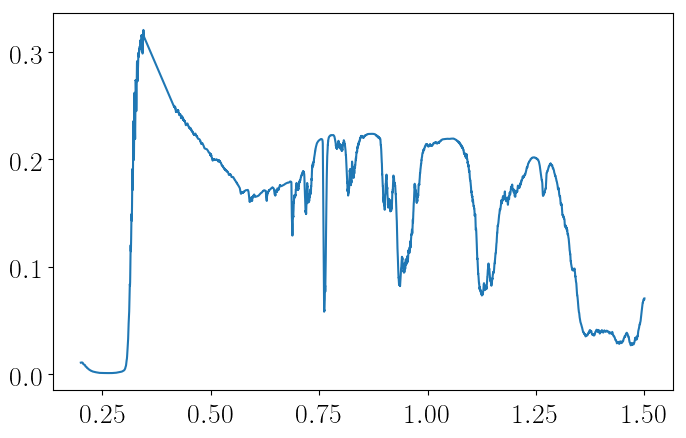

In [8]:
lammin = 0.2
lammax = 1.5
m = (lamhr > lammin) & (lamhr < lammax)

plt.plot(lamhr[m], Ahr[m])

In [376]:
telescope = cg.Telescope(lammin = 0.4, 
                         lammax = 1.4, 
                         R = 140, 
                         Tput = 0.1, 
                         D = 16.
                        )

planet = cg.Planet(d = 5.0, 
                   Rp = 1.0, 
                   a = 1.0, 
                   alpha = 90.0
                  )

star = cg.Star(Teff = 5780., 
               Rs = 1.0
              )

In [377]:
cn = cg.CoronagraphNoise(telescope = telescope, 
                         planet = planet, 
                         star = star, 
                         THERMAL=True)

In [378]:
cn.run_count_rates(Ahr, lamhr, fstar)

In [379]:
cn.make_fake_data(texp = 10)

/Users/Jake/Projects/coronagraph/coronagraph/count_rates.py:348: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  ax.errorbar(self.lam[m], scale*self.Aobs[m], yerr=scale*self.Asig[m], zorder = 100, **err_kws)


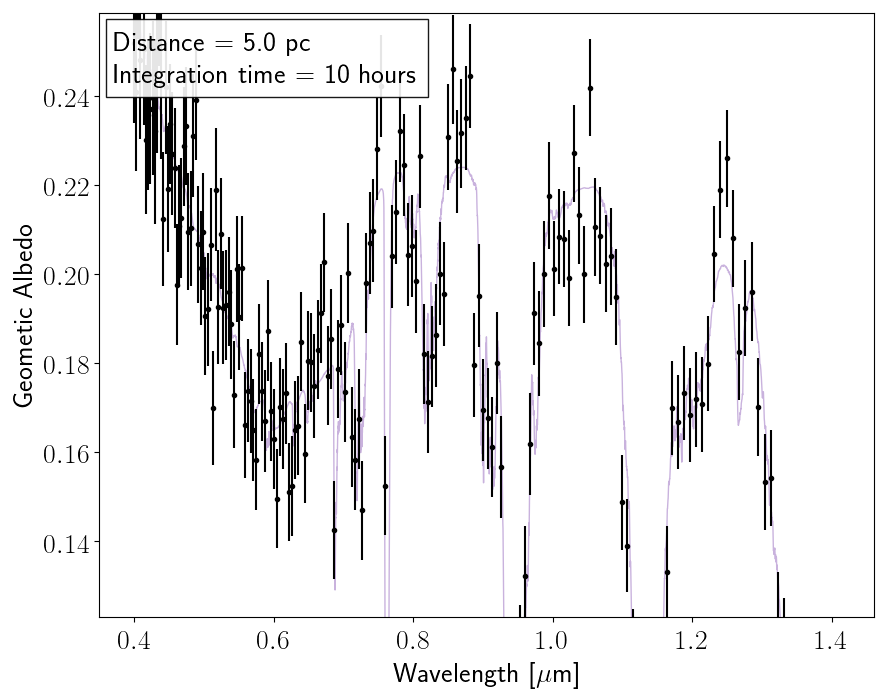

In [13]:
fig, ax = cn.plot_spectrum()

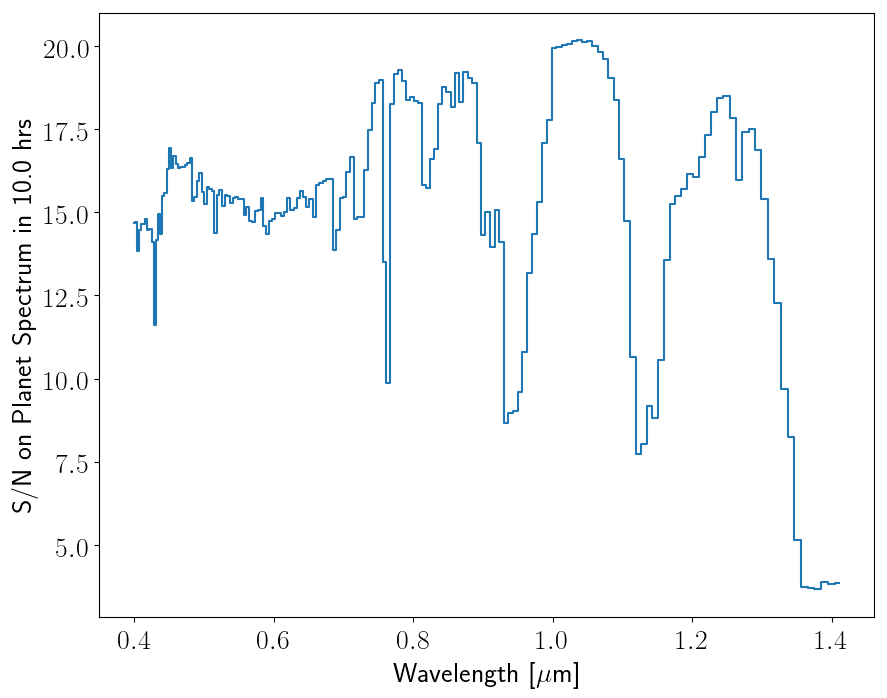

In [14]:
fig, ax = cn.plot_SNR()

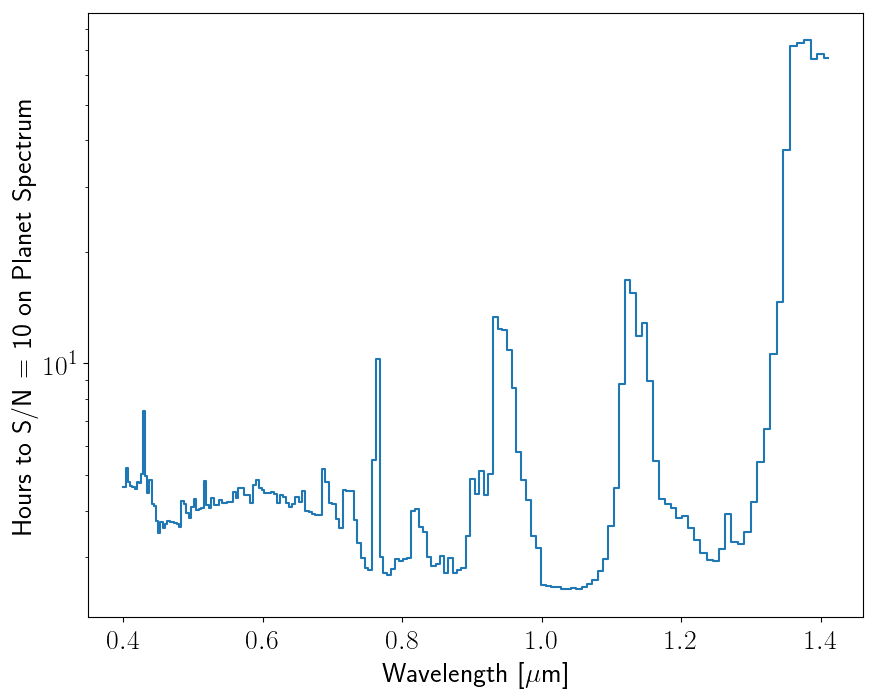

In [15]:
fig, ax = cn.plot_time_to_wantsnr()

In [139]:
# Set nominal SNR and exposure time values
wantSNR = 10.0
wantetime = 5.0
cn.make_fake_data(texp = wantetime)

2.21 hours to SNR = 10.00
SNR = 15.05 on band in a 5.00 hour exposure
SNR = 27.35 on bottom of band in a 5.00 hour exposure


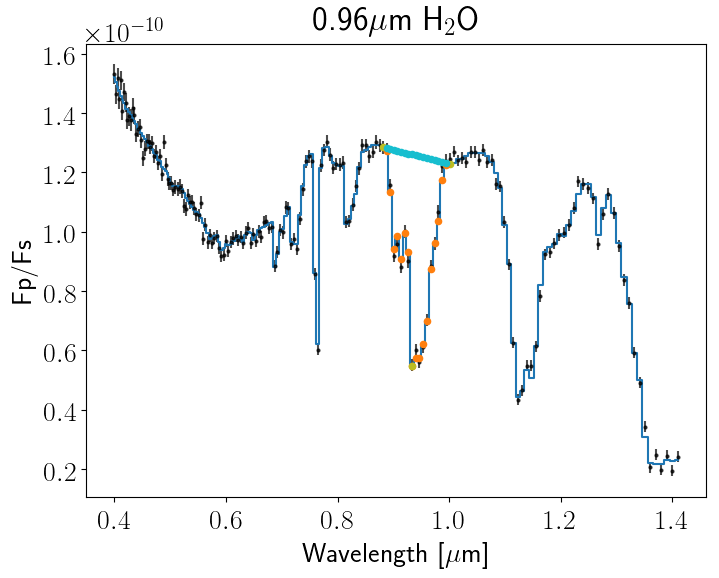

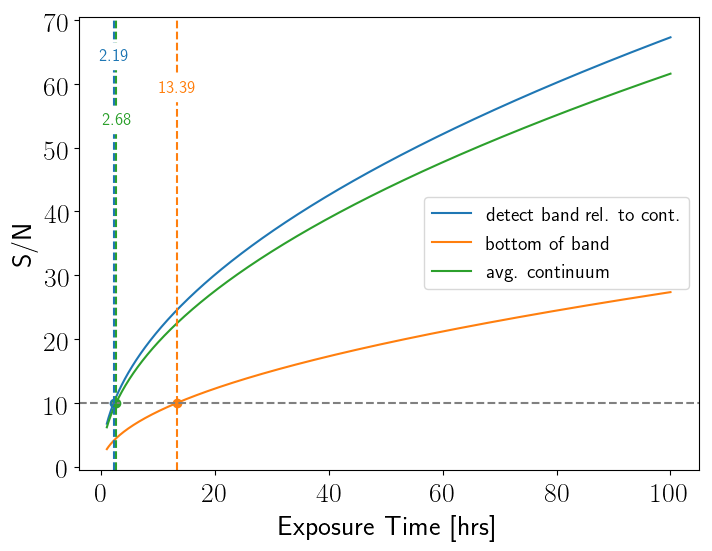

In [147]:
"""
# Specify band via array indices
icont = np.array([111, 128])
iband = np.arange(icont[0]+1, icont[1])
ibottom = 119
"""

# Specify band via wavelength
bandlims = [0.88, 1.0]
icont = np.array([np.argmin(np.fabs(cn.lam - bandlims[0])), np.argmin(np.fabs(cn.lam - bandlims[1]))])
iband = np.arange(icont[0]+1, icont[1])
ibottom = np.argmin(np.fabs(cn.Cratio - np.min(cn.Cratio[iband])))

# Construct noised spectrum plot
fig, ax = plt.subplots(figsize = (8,6))
ax.plot(cn.lam, cn.Cratio, ls = "steps-mid")
ax.errorbar(cn.lam, cn.Cobs, yerr=cn.Csig, fmt = "ok", ms = 2.0, alpha = 0.7)
ax.set_xlabel("Wavelength [$\mu$m]")
ax.set_ylabel("Fp/Fs")
ax.set_title("0.96$\mu$m H$_2$O")

# Identify specific points in band
for i in icont:
    ax.scatter(cn.lam[i], cn.Cratio[i], s = 20.0, c = "C8", marker = "o", zorder = 100)
for i in iband:
    ax.scatter(cn.lam[i], cn.Cratio[i], s = 20.0, c = "C1", marker = "o", zorder = 100)
ax.scatter(cn.lam[ibottom], cn.Cratio[ibottom], s = 20.0, c = "C8", marker = "o", zorder = 100)

# Calculate the continuum planet photon counts and contrast ratio
ccont = cg.observe.interp_cont_over_band(cn.lam, cn.cp, icont, iband)
ccrat = cg.observe.interp_cont_over_band(cn.lam, cn.Cratio, icont, iband)

# Identify specific continuum points in band
for i, ic in enumerate(iband):
    ax.scatter(cn.lam[ic], ccrat[i], s = 20.0, c = "C9", marker = "o", zorder = 100)

# Calculate the exposure time to get desired SNR on band
etime = cg.observe.exptime_band(cn.cp, ccont, cn.cb, iband, SNR=wantSNR)
print("%.2f hours to SNR = %.2f" %(etime, wantSNR))

# Calculate the SNR on band in desired exposure time
eSNR = cg.observe.SNR_band(cn.cp, ccont, cn.cb, iband, itime=wantetime)
print("SNR = %.2f on band in a %.2f hour exposure" %(eSNR, wantetime))

print("SNR = %.2f on bottom of band in a %.2f hour exposure" %(cn.SNRt[ibottom], wantetime))

if True:
    
    # Calculate varies SNRs as a function of exposure time 
    Nt = 1000
    times = np.linspace(1.0, 100.0, Nt)
    band_snrs = np.zeros(len(times))
    bot_snrs = np.zeros(len(times))
    cont_snrs = np.zeros(len(times))
    for i, time in enumerate(times):
        cn.make_fake_data(texp = times[i])
        band_snrs[i] = cg.observe.SNR_band(cn.cp, ccont, cn.cb, iband, itime=times[i])
        bot_snrs[i] = cn.SNRt[ibottom]
        cont_snrs[i] = np.mean(cn.SNRt[icont])

    # Find nearest points to desired values
    #etime_band = cg.observe.exptime_band(cn.cp, ccont, cn.cb, iband, SNR=wantSNR)
    etime_band = times[np.argmin(np.fabs(band_snrs - wantSNR))]
    etime_bot = times[np.argmin(np.fabs(bot_snrs - wantSNR))]
    etime_cont = times[np.argmin(np.fabs(cont_snrs - wantSNR))]

    # Make plot of SNR vs exposure time
    fig, ax = plt.subplots(figsize = (8,6))
    ax.set_xlabel("Exposure Time [hrs]")
    ax.set_ylabel("S/N")
    ax.plot(times, band_snrs, label = "detect band rel. to cont.")
    ax.plot(times, bot_snrs, label = "bottom of band")
    ax.plot(times, cont_snrs, label = "avg. continuum")
    ax.scatter(etime_band, wantSNR, c="C0")
    ax.scatter(etime_bot, wantSNR, c="C1")
    ax.scatter(etime_cont, wantSNR, c="C2")
    ax.axhline(wantSNR, ls = "--", c = "grey")
    ax.axvline(etime_band, ls = "--", c = "C0")
    ax.axvline(etime_bot, ls = "--", c = "C1")
    ax.axvline(etime_cont, ls = "--", c = "C2")
    ylims = ax.get_ylim()
    ax.text(etime_band, ylims[1]-5, "%.2f" %etime_band, ha = "center", va = "top", fontsize = 12, bbox=dict(facecolor='w', alpha=1.0, ec = "w"), color = "C0")
    ax.text(etime_bot, ylims[1]-10, "%.2f" %etime_bot, ha = "center", va = "top", fontsize = 12, bbox=dict(facecolor='w', alpha=1.0, ec = "w"), color = "C1")
    ax.text(etime_cont, ylims[1]-15, "%.2f" %etime_cont, ha = "center", va = "top", fontsize = 12, bbox=dict(facecolor='w', alpha=1.0, ec = "w"), color = "C2")
    ax.legend(framealpha = 0.75, fontsize = 14)

16.48 hours to SNR = 10.00
SNR = 5.51 on band in a 5.00 hour exposure
SNR = 31.20 on bottom of band in a 5.00 hour exposure


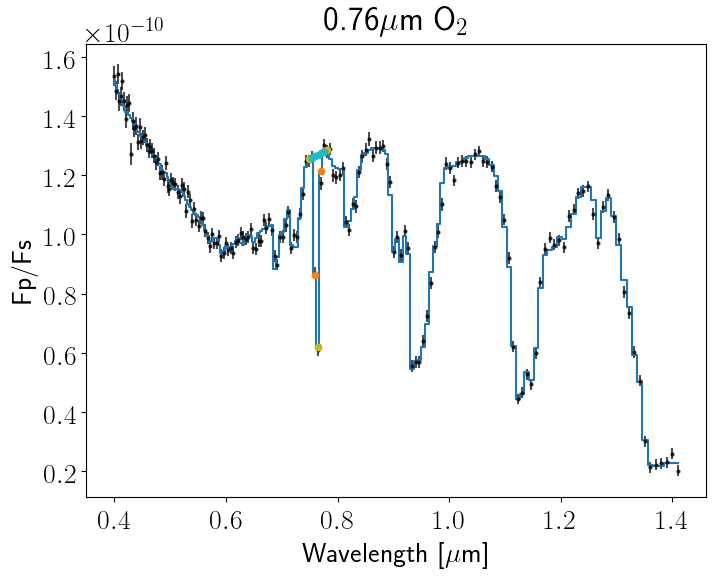

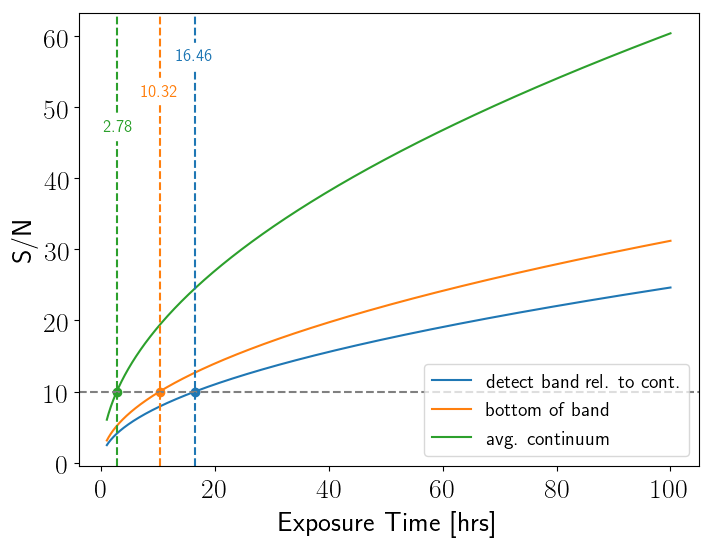

In [151]:
# Specify band via wavelength
bandlims = [0.75, 0.78]
icont = np.array([np.argmin(np.fabs(cn.lam - bandlims[0])), np.argmin(np.fabs(cn.lam - bandlims[1]))])
iband = np.arange(icont[0]+1, icont[1])
ibottom = np.argmin(np.fabs(cn.Cratio - np.min(cn.Cratio[iband])))

# Construct noised spectrum plot
fig, ax = plt.subplots(figsize = (8,6))
ax.plot(cn.lam, cn.Cratio, ls = "steps-mid")
ax.errorbar(cn.lam, cn.Cobs, yerr=cn.Csig, fmt = "ok", ms = 2.0, alpha = 0.7)
ax.set_xlabel("Wavelength [$\mu$m]")
ax.set_ylabel("Fp/Fs")
ax.set_title("0.76$\mu$m O$_2$")

# Identify specific points in band
for i in icont:
    ax.scatter(cn.lam[i], cn.Cratio[i], s = 20.0, c = "C8", marker = "o", zorder = 100)
for i in iband:
    ax.scatter(cn.lam[i], cn.Cratio[i], s = 20.0, c = "C1", marker = "o", zorder = 100)
ax.scatter(cn.lam[ibottom], cn.Cratio[ibottom], s = 20.0, c = "C8", marker = "o", zorder = 100)

# Calculate the continuum planet photon counts and contrast ratio
ccont = cg.observe.interp_cont_over_band(cn.lam, cn.cp, icont, iband)
ccrat = cg.observe.interp_cont_over_band(cn.lam, cn.Cratio, icont, iband)

# Identify specific continuum points in band
for i, ic in enumerate(iband):
    ax.scatter(cn.lam[ic], ccrat[i], s = 20.0, c = "C9", marker = "o", zorder = 100)

# Calculate the exposure time to get desired SNR on band
etime = cg.observe.exptime_band(cn.cp, ccont, cn.cb, iband, SNR=wantSNR)
print("%.2f hours to SNR = %.2f" %(etime, wantSNR))

# Calculate the SNR on band in desired exposure time
eSNR = cg.observe.SNR_band(cn.cp, ccont, cn.cb, iband, itime=wantetime)
print("SNR = %.2f on band in a %.2f hour exposure" %(eSNR, wantetime))

print("SNR = %.2f on bottom of band in a %.2f hour exposure" %(cn.SNRt[ibottom], wantetime))

if True:
    
    # Calculate varies SNRs as a function of exposure time 
    Nt = 1000
    times = np.linspace(1.0, 100.0, Nt)
    band_snrs = np.zeros(len(times))
    bot_snrs = np.zeros(len(times))
    cont_snrs = np.zeros(len(times))
    for i, time in enumerate(times):
        cn.make_fake_data(texp = times[i])
        band_snrs[i] = cg.observe.SNR_band(cn.cp, ccont, cn.cb, iband, itime=times[i])
        bot_snrs[i] = cn.SNRt[ibottom]
        cont_snrs[i] = np.mean(cn.SNRt[icont])

    # Find nearest points to desired values
    #etime_band = cg.observe.exptime_band(cn.cp, ccont, cn.cb, iband, SNR=wantSNR)
    etime_band = times[np.argmin(np.fabs(band_snrs - wantSNR))]
    etime_bot = times[np.argmin(np.fabs(bot_snrs - wantSNR))]
    etime_cont = times[np.argmin(np.fabs(cont_snrs - wantSNR))]

    # Make plot of SNR vs exposure time
    fig, ax = plt.subplots(figsize = (8,6))
    ax.set_xlabel("Exposure Time [hrs]")
    ax.set_ylabel("S/N")
    ax.plot(times, band_snrs, label = "detect band rel. to cont.")
    ax.plot(times, bot_snrs, label = "bottom of band")
    ax.plot(times, cont_snrs, label = "avg. continuum")
    ax.scatter(etime_band, wantSNR, c="C0")
    ax.scatter(etime_bot, wantSNR, c="C1")
    ax.scatter(etime_cont, wantSNR, c="C2")
    ax.axhline(wantSNR, ls = "--", c = "grey")
    ax.axvline(etime_band, ls = "--", c = "C0")
    ax.axvline(etime_bot, ls = "--", c = "C1")
    ax.axvline(etime_cont, ls = "--", c = "C2")
    ylims = ax.get_ylim()
    ax.text(etime_band, ylims[1]-5, "%.2f" %etime_band, ha = "center", va = "top", fontsize = 12, bbox=dict(facecolor='w', alpha=1.0, ec = "w"), color = "C0")
    ax.text(etime_bot, ylims[1]-10, "%.2f" %etime_bot, ha = "center", va = "top", fontsize = 12, bbox=dict(facecolor='w', alpha=1.0, ec = "w"), color = "C1")
    ax.text(etime_cont, ylims[1]-15, "%.2f" %etime_cont, ha = "center", va = "top", fontsize = 12, bbox=dict(facecolor='w', alpha=1.0, ec = "w"), color = "C2")
    ax.legend(framealpha = 0.75, fontsize = 14)

# Refining Code into a useful function

In [380]:
from scipy import stats

def find_time_from_snr(times, snrs, wantsnr):
    """
    Find the exposure time to a given S/N (``wantsnr``) by fitting a curve of 
    S/N (``snrs``) vs. time (``times``) and solving for the time at ``wantsnr``.
    
    Parameters
    ----------
    times : array-like
    snrs : array-like
    wantsnr : float
    
    Returns
    -------
    t_snr : float
        Time to ``wantsnr`` [same units as ``times``]
    """
    
    x = times
    y = snrs**2
    
    # Fit S/N**2 curve with a line
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    y_fit = slope * x + intercept
    snr_fit = np.sqrt(y_fit)

    # Solve for number of occultations to get desired SNR
    t_snr = (wantsnr**2 - intercept) / slope
    
    return t_snr

def determine_exposure_time(cn, bandlims, wantSNR = 10.0, wantetime = 5.0, ref_lam = 0.550, 
                            plot_snr_curves = False, plot_spectrum = False, 
                            title = ""):
    """
    Determine the exposure time needed to get a desired S/N
    
    Parameters
    ----------
    cn : :class:`coronagraph.CoronagraphNoise`
        Instantiated ``CoronagraphNoise`` object containing ``Telescope``, ``Planet``, and ``Star`` 
        objects with their associated parameters
    bandlims : list or tuple
        Lower and upper wavelength limits to absorption band [microns]
        
    Returns
    -------
    etime_band : float 
        Exposure time to get S/N on band below the continuum
    etime_bot : float 
        Exposure time to get S/N on spectral element at the bottom of the band
    etime_cont : float
        Exposure time to ger S/N on the spectral elements in the continuum nearest to the band
    """
    
    # Specify Kat's fiducial S/N
    iref = np.argmin(np.fabs(cn.lam - ref_lam))
    
    if bandlims is not None:
    
        # Specify band via wavelength
        icont = np.array([np.argmin(np.fabs(cn.lam - bandlims[0])), np.argmin(np.fabs(cn.lam - bandlims[1]))])
        iband = np.arange(icont[0]+1, icont[1])
        ibottom = np.argmin(np.fabs(cn.Cratio - np.min(cn.Cratio[iband])))

        # Calculate the continuum planet photon counts and contrast ratio
        ccont = cg.observe.interp_cont_over_band(cn.lam, cn.cp, icont, iband)
        ccrat = cg.observe.interp_cont_over_band(cn.lam, cn.Cratio, icont, iband)

    # Calculate varies SNRs as a function of exposure time 
    Nt = 1000
    times = np.linspace(1.0, 100.0, Nt)
    band_snrs = np.zeros(len(times))
    bot_snrs = np.zeros(len(times))
    cont_snrs = np.zeros(len(times))
    fid_snrs = np.zeros(len(times))
    for i, time in enumerate(times):
        cn.make_fake_data(texp = times[i])
        fid_snrs[i] = cn.SNRt[iref]
        if bandlims is not None:
            band_snrs[i] = cg.observe.SNR_band(cn.cp, ccont, cn.cb, iband, itime=times[i])
            bot_snrs[i] = cn.SNRt[ibottom]
            cont_snrs[i] = np.mean(cn.SNRt[icont])
    
    # Fit for time to desired snr value
    etime_fid = find_time_from_snr(times, fid_snrs, wantSNR) #times[np.argmin(np.fabs(fid_snrs - wantSNR))]
    if bandlims is not None: 
        etime_band = find_time_from_snr(times, band_snrs, wantSNR) #times[np.argmin(np.fabs(band_snrs - wantSNR))]
        etime_bot = find_time_from_snr(times, bot_snrs, wantSNR) #times[np.argmin(np.fabs(bot_snrs - wantSNR))]
        etime_cont = find_time_from_snr(times, cont_snrs, wantSNR) #times[np.argmin(np.fabs(cont_snrs - wantSNR))]
    
    # Check for incomplete bands which can cause anomalously low exposure times
    if  bandlims is None:
        etime_band = np.nan
        etime_bot = np.nan
        etime_cont = np.nan
    else:
        if (False in np.isfinite(cn.Cobs[iband])):
            etime_band = np.nan
            
    # Make plot of SNR vs exposure time
    if plot_snr_curves:
        
        fig, ax = plt.subplots(figsize = (8,6))
        ax.set_xlabel("Exposure Time [hrs]")
        ax.set_ylabel("S/N")
        if bandlims is not None: 
            ax.plot(times, band_snrs, label = "detect band rel. to cont.")
            ax.plot(times, bot_snrs, label = "bottom of band")
            ax.plot(times, cont_snrs, label = "avg. continuum")
        ax.plot(times, fid_snrs, label = "at %.2f $\mu$m" %cn.lam[iref])
        if bandlims is not None: 
            ax.scatter(etime_band, wantSNR, c="C0")
            ax.scatter(etime_bot, wantSNR, c="C1")
            ax.scatter(etime_cont, wantSNR, c="C2")
        ax.scatter(etime_fid, wantSNR, c="C3")
        ax.axhline(wantSNR, ls = "--", c = "grey")
        if bandlims is not None: 
            ax.axvline(etime_band, ls = "--", c = "C0")
            ax.axvline(etime_bot, ls = "--", c = "C1")
            ax.axvline(etime_cont, ls = "--", c = "C2")
        ax.axvline(etime_fid, ls = "--", c = "C3")
        ylims = ax.get_ylim()
        if bandlims is not None: 
            ax.text(etime_band, ylims[1]-.5*ylims[1], "%.2f" %etime_band, ha = "center", va = "top", fontsize = 12, bbox=dict(facecolor='w', alpha=1.0, ec = "w"), color = "C0")
            ax.text(etime_bot, ylims[1]-.1*ylims[1], "%.2f" %etime_bot, ha = "center", va = "top", fontsize = 12, bbox=dict(facecolor='w', alpha=1.0, ec = "w"), color = "C1")
            ax.text(etime_cont, ylims[1]-.15*ylims[1], "%.2f" %etime_cont, ha = "center", va = "top", fontsize = 12, bbox=dict(facecolor='w', alpha=1.0, ec = "w"), color = "C2")
        ax.text(etime_fid, ylims[1]-.20*ylims[1], "%.2f" %etime_fid, ha = "center", va = "top", fontsize = 12, bbox=dict(facecolor='w', alpha=1.0, ec = "w"), color = "C3")
        ax.legend(framealpha = 0.75, fontsize = 14)
        
    if plot_spectrum:
        
        # Construct noised spectrum plot
        if bandlims is not None:
            cn.make_fake_data(texp = etime_band)
        else:
            cn.make_fake_data(texp = etime_fid)
        
        fig, ax = plt.subplots(figsize = (8,6))
        ax.plot(cn.lam, cn.Cratio, ls = "steps-mid", color = "grey")
        ax.errorbar(cn.lam, cn.Cobs, yerr=cn.Csig, fmt = "o", ms = 2.0, alpha = 0.7, color = "k")
        ax.set_xlabel("Wavelength [$\mu$m]")
        ax.set_ylabel("Fp/Fs")
        ax.set_title(title)
        
        if bandlims is not None:
            # Identify specific points in band
            for i in icont:
                ax.scatter(cn.lam[i], cn.Cratio[i], s = 20.0, c = "C8", marker = "o", zorder = 100)
            for i in iband:
                ax.scatter(cn.lam[i], cn.Cratio[i], s = 20.0, c = "C1", marker = "o", zorder = 100)
            ax.scatter(cn.lam[ibottom], cn.Cratio[ibottom], s = 20.0, c = "C8", marker = "o", zorder = 100)
            # Identify specific continuum points in band
            for i, ic in enumerate(iband):
                ax.scatter(cn.lam[ic], ccrat[i], s = 20.0, c = "C9", marker = "o", zorder = 100)
            
    # Return exposure times
    return etime_band, etime_bot, etime_cont, etime_fid
        

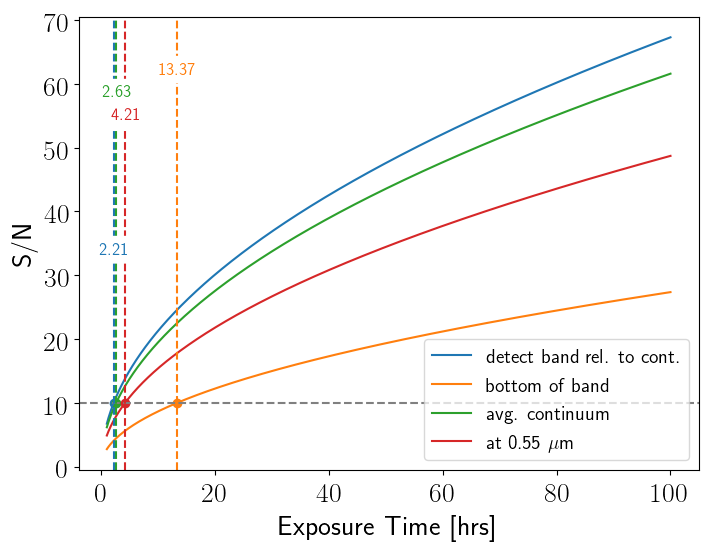

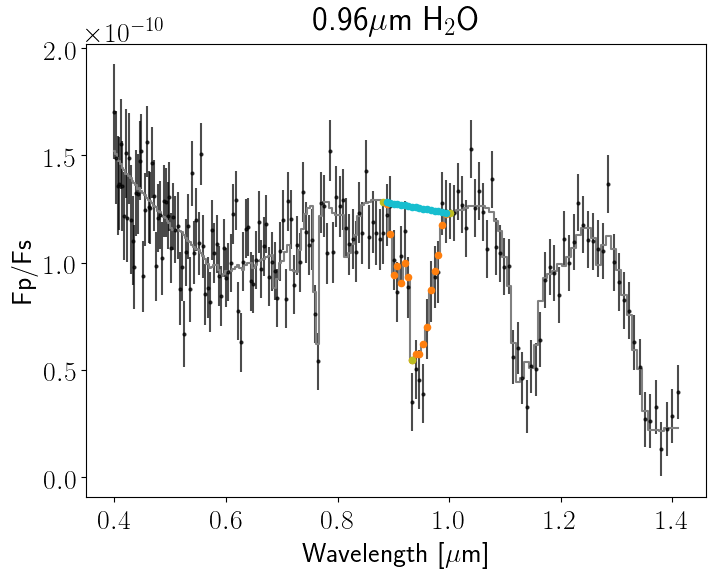

In [17]:
etimes = determine_exposure_time(cn, [0.88, 1.0], title = "0.96$\mu$m H$_2$O", plot_snr_curves=True, plot_spectrum=True)

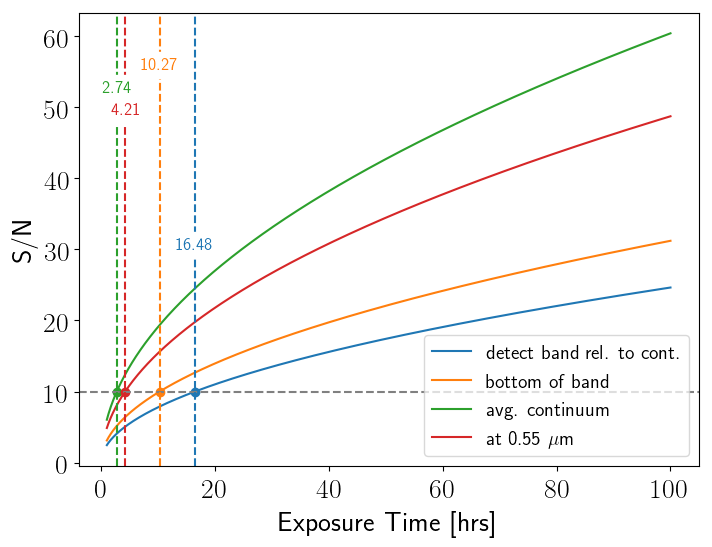

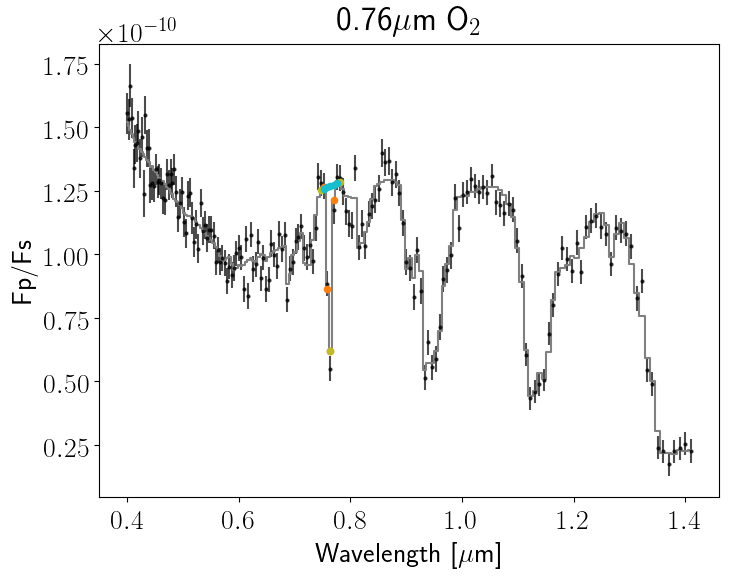

In [381]:
etimes = determine_exposure_time(cn, [0.75, 0.78], title = "0.76$\mu$m O$_2$", plot_snr_curves=True, plot_spectrum=True)

In [386]:
t_o2A = etimes[0]
t_550 = etimes[3]

10.0 * (t_o2A / t_550)**(-0.5)

5.055996537339318

# Using the code

Load-in Exoplanet Spectrum:

In [14]:
lamhr, Ahr, fstar = cg.get_earth_reflect_spectrum()

Set telescope, planet, and star parameters:

In [15]:
telescope = cg.Telescope(lammin = 0.4, 
                         lammax = 1.4, 
                         R = 140, 
                         Tput = 0.1, 
                         D = 16.
                        )

planet = cg.Planet(d = 5.0, 
                   Rp = 1.0, 
                   a = 1.0, 
                   alpha = 90.0
                  )

star = cg.Star(Teff = 5780., 
               Rs = 1.0
              )

Create a simulation that holds the above parameters:

In [16]:
cn = cg.CoronagraphNoise(telescope = telescope, 
                         planet = planet, 
                         star = star, 
                         THERMAL=True)

Calculate the photon count rates for observing this spectrum with the specified telescope and system setup:

In [17]:
cn.run_count_rates(Ahr, lamhr, fstar)

Determine the exposure time for a single band:

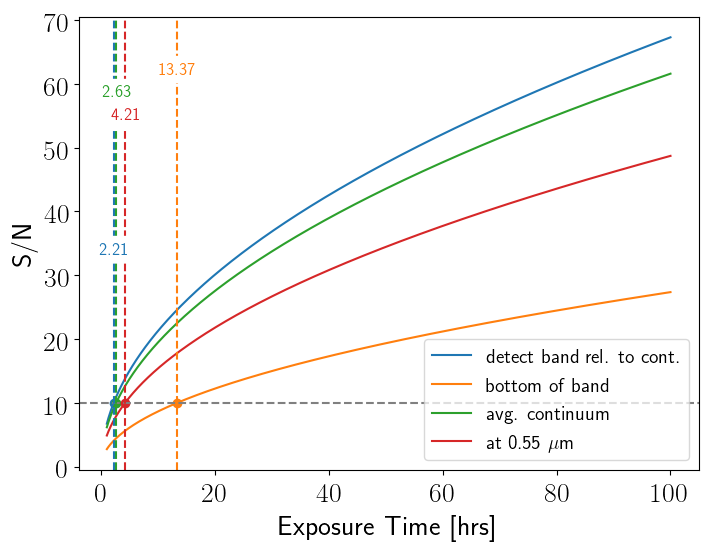

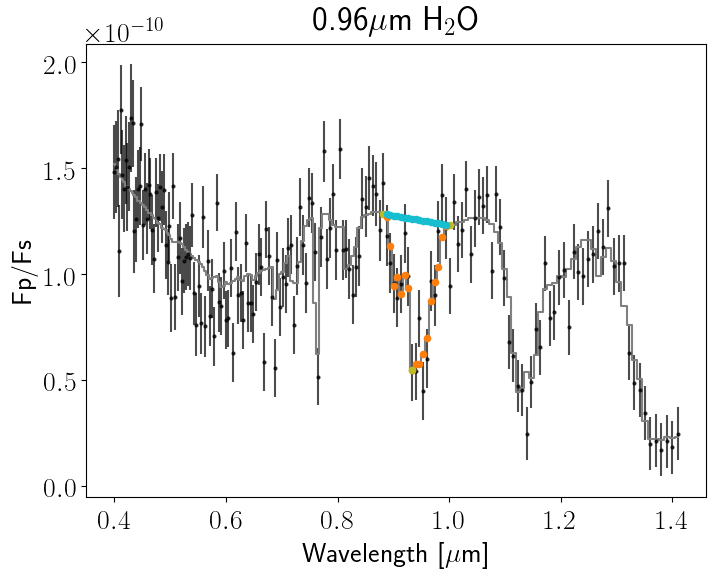

In [22]:
etimes = determine_exposure_time(cn, [0.88, 1.0], title = "0.96$\mu$m H$_2$O", plot_snr_curves=True, plot_spectrum=True)

# Applying to some real systems

In [18]:
from astroquery.simbad import Simbad
from astropy.table import Table, vstack

def read_simbad_table(obj_name, **kwargs):
    """Read in Astroquery results from Simbad given object name (str)
    
    Parameter
    ---------
    obj_name : (str or list of str) name(s) of object
    
    kwargs (optional)
    ------
    votfields : (list) list of votable field keywords, from http://simbad.u-strasbg.fr/Pages/guide/sim-fscript.htx
                default is ['sptype', 'fluxdata(V)', 'velocity', 'distance']
    """
    customSimbad = Simbad()
    votfields = kwargs.pop('votfields', ['sptype', 'fluxdata(V)', 'velocity', 'distance'])
#    customSimbad.add_votable_fields('sptype')
#    customSimbad.add_votable_fields('fluxdata(V)')
#    customSimbad.add_votable_fields('velocity')
#    customSimbad.add_votable_fields('distance')
    for vf in votfields:
        customSimbad.add_votable_fields(vf)
    if type(obj_name) is str:
        result_table = customSimbad.query_object(obj_name)
    else:
        result_table = customSimbad.query_objects(obj_name)
    return result_table

In [19]:
## read in the biased draw from Aki and make 5 unbiased draws from them
Ndraw=5
obj_names_all = np.loadtxt('../inputs/luvoir-A_stars.txt', usecols=(0,), delimiter=',', skiprows=1).astype(int)
obj_names = np.random.choice(obj_names_all, size=Ndraw, replace=False)
print(obj_names)

votfields = ['sptype', 'fluxdata(V)', 'distance', 'diameter', 'fe_h']

## stack each Simbad query results vertically in Astropy Table
result = read_simbad_table("Hip"+str(obj_names[0]), votfields = votfields)
for ii in range(1,len(obj_names)):
    result = vstack([result, read_simbad_table("Hip"+str(obj_names[ii]))])
    
print(result)

[22263 86796 36439 48113 77358]


 MAIN_ID        RA           DEC      ... RVZ_WAVELENGTH     RVZ_BIBCODE    
             "h:m:s"       "d:m:s"    ...                                   
--------- ------------- ------------- ... -------------- -------------------
*  58 Eri 04 47 36.2917 -16 56 04.041 ...             --                  --
* mu. Ara 17 44 08.7036 -51 50 02.591 ...              O 2018yCat.1345....0G
*  22 Lyn 07 29 55.9568 +49 40 20.861 ...                2010A&A...521A..12M
*  15 LMi 09 48 35.3713 +46 01 15.633 ...                2002ApJS..141..503N
HD 140901 15 47 29.1006 -37 54 58.722 ...              O 2018yCat.1345....0G


In [25]:
result

MAIN_ID,RA,DEC,RA_PREC,DEC_PREC,COO_ERR_MAJA,COO_ERR_MINA,COO_ERR_ANGLE,COO_QUAL,COO_WAVELENGTH,COO_BIBCODE,SP_TYPE,SP_QUAL,SP_BIBCODE,FILTER_NAME_V,FLUX_V,FLUX_ERROR_V,FLUX_SYSTEM_V,FLUX_BIBCODE_V,FLUX_VAR_V,FLUX_MULT_V,FLUX_QUAL_V,FLUX_UNIT_V,Distance_distance,Distance_Q,Distance_unit,Distance_merr,Distance_perr,Distance_method,Distance_bibcode,Diameter_diameter,Diameter_Q,Diameter_unit,Diameter_error,Diameter_filter,Diameter_method,Diameter_bibcode,Fe_H_Teff,Fe_H_log_g,Fe_H_Fe_H,Fe_H_flag,Fe_H_CompStar,Fe_H_CatNo,Fe_H_bibcode,RVZ_TYPE,RVZ_RADVEL,RVZ_ERROR,RVZ_QUAL,RVZ_WAVELENGTH,RVZ_BIBCODE
,"""h:m:s""","""d:m:s""",,,mas,mas,deg,,,,,,,,mag,,,,,,,,,,,,,,,,,,,,,,unit-degK,cm/s**2,,,,,,,km / s,km / s,,,
object,unicode13,unicode13,int16,int16,float32,float32,int16,unicode1,unicode1,object,object,unicode1,object,object,float32,float32,object,object,unicode1,object,unicode1,unicode1,float64,unicode1,unicode4,float64,float64,unicode8,unicode19,float64,unicode1,unicode4,float64,unicode8,unicode8,unicode19,int32,float32,float32,unicode1,object,unicode5,unicode19,unicode1,float64,float32,unicode1,unicode1,object
HD 125072,14 19 04.8341,-59 22 44.535,14,14,0.025,0.027,90,A,O,2018yCat.1345....0G,K3IV,C,2006AJ....132..161G,V,6.66,--,Vega,,,,C,V,11.8408,,pc,-0.0049,0.0049,paral,2018yCat.1345....0G,--,,,--,,,,5007,4.5600,0.180,,SUN,,2008A&A...487..373S,--,--,--,--,--,--
HD 140901,15 47 29.1006,-37 54 58.722,14,14,0.041,0.025,90,A,O,2018yCat.1345....0G,G7IV,C,2006A&A...460..695T,V,6.01,--,Vega,,,,C,V,15.2595,,pc,-0.0111,0.0111,paral,2018yCat.1345....0G,--,--,--,--,--,--,--,--,--,--,--,--,--,--,v,-6.740,0.160,A,O,2018yCat.1345....0G
* tau Cet,01 44 04.0834,-15 56 14.926,11,11,0.140,0.130,90,A,O,2007A&A...474..653V,G8V,B,1989ApJS...71..245K,V,3.5,--,Vega,2002yCat.2237....0D,,,C,V,3.6033,,pc,-0.0067,0.0067,paral,2018yCat.1345....0G,--,--,--,--,--,--,--,--,--,--,--,--,--,--,v,-16.680,0.050,A,,2002ApJS..141..503N
* 50 Per,04 08 36.6168,+38 02 23.055,14,14,0.097,0.059,90,A,O,2018yCat.1345....0G,F7V,E,,V,5.5,--,Vega,,,,C,V,21.3150,,pc,-0.0530,0.0530,paral,2018yCat.1345....0G,--,--,--,--,--,--,--,--,--,--,--,--,--,--,v,26.350,0.180,A,,2010A&A...521A..12M
HD 189567,20 05 32.7652,-67 19 15.228,14,14,0.021,0.032,90,A,O,2018yCat.1345....0G,G2V,C,2006AJ....132..161G,V,6.07,--,Vega,2002yCat.2237....0D,,,C,V,17.9148,,pc,-0.0122,0.0122,paral,2018yCat.1345....0G,--,--,--,--,--,--,--,--,--,--,--,--,--,--,v,-10.610,0.150,A,O,2018yCat.1345....0G


In [20]:
# Read in table of 50 biased draws 
data = np.loadtxt('../inputs/luvoir-A_stars.txt', delimiter=',', skiprows=1, dtype = str)

# Parse
hip = np.array(data[:,0], dtype=int)
dist = np.array(data[:,1], dtype=float)
stype = np.array(data[:,2], dtype=str)

In [21]:
def read_luvoir_stars(path = '../inputs/luvoir-A_stars.txt'):
    """
    Read-in file of stars in the biased list from Aki and Chris
    """
    
    # Read in table of 50 biased draws 
    data = np.loadtxt(path, delimiter=',', skiprows=1, dtype = str)

    # Parse
    hip = np.array(data[:,0], dtype=int)
    dist = np.array(data[:,1], dtype=float)
    stype = np.array(data[:,2], dtype=str)
    
    return hip, dist, stype

In [22]:
# Read in table of stellar types
data = np.loadtxt('../inputs/stellar_properties.txt', skiprows=19, dtype = str)
data = pd.DataFrame(data, columns=["Stellar Type", "Mass", "Luminosity", "Radius", "Temp", 
                                   "B-V", "Mv", "BC(Temp)", "Mbol", "R", "G", "B"])
data.head()

,Stellar Type,Mass,Luminosity,Radius,Temp,B-V,Mv,BC(Temp),Mbol,R,G,B
0,O0Ia0,160.0,3.41e+07,8.02e+01,50000,-0.35,-9.5,-4.58,-14.08,144,166,255
1,O0Ia,150.0,2.59e+06,2.21e+01,50000,-0.35,-6.7,-4.58,-11.28,144,166,255
2,O0Ib,140.0,2.15e+06,2.02e+01,50000,-0.35,-6.5,-4.58,-11.08,144,166,255
3,O0II,130.0,2.15e+06,2.02e+01,50000,-0.35,-6.5,-4.58,-11.08,144,166,255
4,O0III,120.0,2.15e+06,2.02e+01,50000,-0.35,-6.5,-4.58,-11.08,144,166,255


In [23]:
# Read in table of stellar types
data = np.loadtxt('../inputs/stellar_properties.txt', skiprows=19, dtype = str)

stypes = data[:,0] 
masses = np.array(data[:,1], dtype=float)
lums = np.array(data[:,2], dtype=float)
rads = np.array(data[:,3], dtype=float)
temps = np.array(data[:,4], dtype=float)
mvs = np.array(data[:,6], dtype=float)

In [24]:
def read_stellar_properties():
    """
    Read-in file of stellar properties
    """
    
    # Read in table of stellar types
    data = np.loadtxt('../inputs/stellar_properties.txt', skiprows=19, dtype = str)

    # Parse
    stypes = data[:,0] 
    masses = np.array(data[:,1], dtype=float)
    lums = np.array(data[:,2], dtype=float)
    rads = np.array(data[:,3], dtype=float)
    temps = np.array(data[:,4], dtype=float)
    mvs = np.array(data[:,6], dtype=float)
    
    # Construct dictionary
    sdic = {
        "stypes" : stypes, 
        "masses" : masses, 
        "lums" : lums, 
        "rads" : rads, 
        "temps" : temps, 
        "mvs" : mvs
    }

    return sdic

In [25]:
def match_stellar_type(s, verbose = True):
    """
    Match stellar type ``s`` with the table of stellar types and return the index in table 
    that matches
    """
    for i, st in enumerate(stypes):
        if s == st:
            return i
    if verbose: print("No exact match found")
    for i, st in enumerate(stypes):
        if s.startswith(st):
            if verbose: print("Using %s for %s" %(st, s))
            return i
    for i, st in enumerate(stypes):
        if s.endswith(st):
            if verbose: print("Using %s for %s" %(st, s))
            return i
    for i, st in enumerate(stypes):
        if s+"V" == st:
            if verbose: print("Using %s for %s" %(st, s))
            return i

In [26]:
Ndraw = 5
np.random.seed(seed=1)
idraw = np.random.choice(np.arange(len(hip)), size=Ndraw, replace=False)

In [27]:
print("Randomly Drawn Stars")
print("--------------------")
for i in idraw:
    print("HIP %i, %.2f pc, %s " %(hip[i], dist[i], stype[i]))
    print(stypes[match_stellar_type(stype[i])])

Randomly Drawn Stars
--------------------
HIP 19335, 21.26 pc, F7V 
F7V
HIP 57757, 10.93 pc, F8V 
F8V
HIP 116085, 16.87 pc, K2V 
K2V
HIP 48113, 18.37 pc, G2V 
G2V
HIP 15371, 12.03 pc, G1V 
G1V


### The Habitable Zone

Using the HZs for different stellar types from [Kopparapu et al. (2013)](http://iopscience.iop.org/article/10.1088/0004-637X/765/2/131/meta):

In [28]:
def calc_seff(Teff, S0, coeffs):
    a, b, c, d = coeffs
    T = Teff - 5780.
    return S0 + a*T + b*T**2 + c*T**3 + d*T**4

def calc_dist(L, Seff):
    return (L / Seff)**0.5

# Using the moist greenhouse inner edge
S0_inner = 1.0140
inner_edge = [8.1774e-5, 1.7063e-9, -4.3241e-12, -6.6462e-16]

# Using the maximum greenhouse outer edge
S0_outer = 0.3438
outer_edge = [5.8942e-5, 1.6558e-9, -3.0045e-12, -5.2983e-16]

In [29]:
Ndraw = 1
idraw = np.random.choice(np.arange(len(hip)), size=Ndraw, replace=False)

print("Randomly Drawn Stars")
print("--------------------")
for i in idraw:
    print("HIP %i, %.2f pc, %s " %(hip[i], dist[i], stype[i]))
    imatch = match_stellar_type(stype[i])
    print(stypes[imatch])
    a_in = calc_dist(lums[imatch], calc_seff(temps[imatch], S0_inner, inner_edge))
    a_out = calc_dist(lums[imatch], calc_seff(temps[imatch], S0_outer, outer_edge))
    print("HZ limits : %.2f - %.2f au" %(a_in, a_out))
    a_eeq = np.sqrt(lums[imatch])
    print("Earth-Equivalent Insolation Distance : %.2f au" %a_eeq)

Randomly Drawn Stars
--------------------
HIP 5862, 15.11 pc, F8V 
F8V
HZ limits : 1.51 - 2.54 au
Earth-Equivalent Insolation Distance : 1.55 au


# Example random sampling

In [30]:
def nsig_intervals(x, intvls=[0.16, 0.5, 0.84]):
    # Compute median and n-sigma intervals
    q_l, q_50, q_h = np.percentile(x, list(100.0 * np.array(intvls)))
    q_m, q_p = q_50-q_l, q_h-q_50
    return q_l, q_50, q_h, q_m, q_p

In [443]:
Xdraw = 200    # Number for unbiased random samples
Ndraw = 5      # Number of stars to randomly draw from biased sample

np.random.seed(seed=None)

# Allocate memory for exposure times
ctime_band = np.zeros((Ndraw, Xdraw))
ctime_bot = np.zeros((Ndraw, Xdraw))
ctime_cont = np.zeros((Ndraw, Xdraw))
ctime_fid = np.zeros((Ndraw, Xdraw))

# Loop over number of random draws (for bootstrapping distributions)
for ix in range(Xdraw):
    
    # Randomly draw sample indices
    idraw = np.random.choice(np.arange(len(hip)), size=Ndraw, replace=False)
    
    # Order systems by "detectability"
    idraw = idraw[np.argsort(dist[idraw])]   # Simply distance for now
    
    # Loop over stars in this sample
    for i, j in enumerate(idraw):
        #print("HIP %i, %.2f pc, %s " %(hip[j], dist[j], stype[j]))
        
        # Get index with matching stellar type in stellar properties table
        imatch = match_stellar_type(stype[j], verbose = False)
        
        # Set system distance
        cn.planet.distance = dist[j]
        
        # Set stellar temperature
        cn.star.Teff = temps[imatch]
        
        # Set stellar radius
        cn.star.Rs = rads[imatch]
        
        # Calculate the Earth-equivalent insolation distance
        a_eeq = np.sqrt(lums[imatch])
        
        # Set semi-major axis 
        cn.planet.a = a_eeq
        
        # Set stellar spectrum based on type
        # Calculate stellar flux at TOA assuming a blackbody
        Fs = cg.noise_routines.Fstar(lamhr, cn.star.Teff, cn.star.Rs, cn.planet.a, AU=True)
        #Fs = fstar
        
        # Run count rates
        cn.run_count_rates(Ahr, lamhr, Fs)
        etimes = determine_exposure_time(cn, [0.88, 1.0], title = "0.96$\mu$m H$_2$O", plot_snr_curves=False, plot_spectrum=False)
        #etime_band, etime_bot, etime_cont, etime_fid = etimes
        
        # Parse and distribute results
        ctime_band[i, ix] += etimes[0]
        ctime_bot[i, ix] += etimes[1]
        ctime_cont[i, ix] += etimes[2]
        ctime_fid[i, ix] += etimes[3]
    
#print(ctime_band, ctime_bot, ctime_cont)

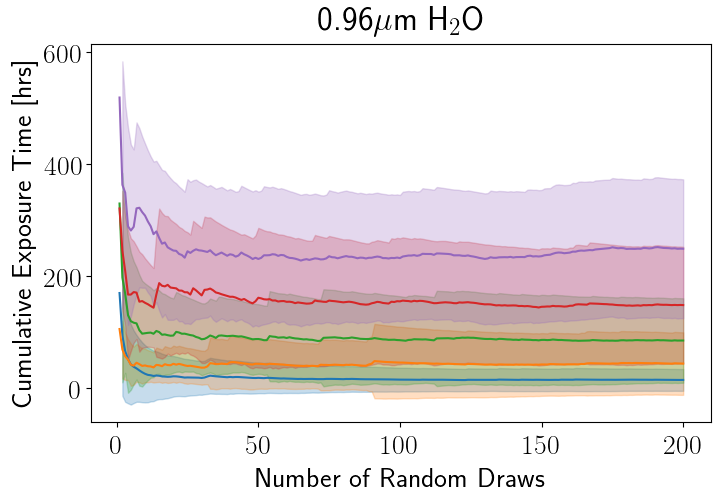

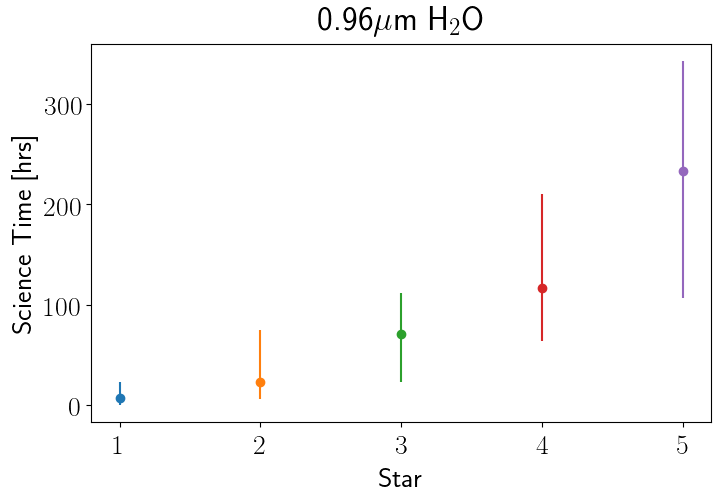

In [448]:
fig, ax = plt.subplots()
fig2, ax2 = plt.subplots()

# Loop over stars in sample
for i in range(Ndraw):
    
    # Calculate the cumulative mean time (to estimate convergence)
    cummean = pd.Series(ctime_band[i,:]).expanding(1).mean().values
    
    # Calculate the cumulative std deviation 
    cumstd = pd.Series(ctime_band[i,:]).expanding(1).std().values
    
    # Plot
    ax.plot((np.arange(Xdraw)+1), cummean, c = "C%i" %i)
    #ax.errorbar(np.arange(Xdraw)+1, cummean, yerr=cumstd)
    ax.fill_between(np.arange(Xdraw)+1, cummean - cumstd, cummean + cumstd, alpha = 0.25, color = "C%i" %i)
    ax.set_xlabel("Number of Random Draws")
    ax.set_ylabel("Cumulative Exposure Time [hrs]")
    ax.set_title("0.96$\mu$m H$_2$O")
    
    q_l, q_50, q_h, q_m, q_p = nsig_intervals(ctime_band[i,:], intvls=[0.16, 0.5, 0.84])
    ax2.errorbar(i+1, q_50, yerr = np.array([q_m, q_p]).reshape((2,1)), fmt = "o", color = "C%i" %i)
    ax2.set_xlabel("Star")
    ax2.set_ylabel("Science Time [hrs]")
    ax2.set_title("0.96$\mu$m H$_2$O")
    #ax2.set_yscale("log")

In [31]:
def prep_ith_star(cn, i):
    """
    Takes a :class:`coronagraph.CoronagraphNoise` object and an index and returns the object 
    with parameters set for that system. 
    
    Note
    ----
    Currently requires a bunch of arrays to exist outside of this functions scope, 
    e.g. `stype`, `dist`, `temps`, `rads`, `lums`
    """
    
    # Get index with matching stellar type in stellar properties table
    imatch = match_stellar_type(stype[i], verbose = False)
    
    # Set system distance
    cn.planet.distance = dist[i]

    # Set stellar temperature
    cn.star.Teff = temps[imatch]

    # Set stellar radius
    cn.star.Rs = rads[imatch]

    # Calculate the Earth-equivalent insolation distance
    a_eeq = np.sqrt(lums[imatch])

    # Set semi-major axis 
    cn.planet.a = a_eeq

    # Set stellar spectrum based on type
    # Calculate stellar flux at TOA assuming a blackbody
    Fs = cg.noise_routines.Fstar(lamhr, cn.star.Teff, cn.star.Rs, cn.planet.a, AU=True)
    #Fs = fstar

    # Run count rates
    cn.run_count_rates(Ahr, lamhr, Fs)
    
    return cn

### Use "True" LUVOIR parameters

In [32]:
def default_luvoir(architecture = "A", channel = "vis"):
    """
    Returns the :class:`coronagraph.Telescope` for the `architecture` and 
    `channel` specified by the user. 
    """
    
    telescope = cg.Telescope()
    
    # Set paramaters for Architecture A
    if (architecture.lower() == "A".lower()):
        telescope.diameter = 13.5
        telescope.A_collect = 155.
        telescope.Tsys = 270.
        telescope.OWA = 64.
        if channel.lower() == "vis".lower():
            telescope.IWA = 3.5
            telescope.resolution = 150.
            telescope.throughput = 0.15
            telescope.darkcurrent = 3e-5
            telescope.readnoise = 1e-2
            telescope.lammin = 0.5
            telescope.lammax = 1.03
        elif channel.lower() == "UV".lower():
            telescope.IWA = 3.5
            telescope.resolution = 10.
            telescope.throughput = 0.15
            telescope.darkcurrent = 3e-5
            telescope.readnoise = 1e-2
            telescope.lammin = 0.2
            telescope.lammax = 0.5
        elif channel.lower() == "NIR".lower():
            telescope.IWA = 2.4
            telescope.resolution = 150.
            telescope.throughput = 0.15
            telescope.darkcurrent = 2e-3
            telescope.readnoise = 2.5
            telescope.lammin = 1.03
            telescope.lammax = 1.8
        else:
            print("Unknown `channel`")
            return None
    
    # Set paramaters for Architecture B
    elif (architecture.lower() == "B".lower()):
        telescope.diameter = 6.7
        telescope.A_collect = 43.8
        telescope.Tsys = 270.
        telescope.OWA = 64.
        if channel.lower() == "vis".lower():
            telescope.IWA = 2.4
            telescope.resolution = 150.
            telescope.throughput = 0.18
            telescope.darkcurrent = 3e-5
            telescope.readnoise = 1e-2
            telescope.lammin = 0.5
            telescope.lammax = 1.03
        elif channel.lower() == "UV".lower():
            telescope.IWA = 3.5
            telescope.resolution = 10.
            telescope.throughput = 0.18
            telescope.darkcurrent = 3e-5
            telescope.readnoise = 1e-2
            telescope.lammin = 0.2
            telescope.lammax = 0.5
        elif channel.lower() == "NIR".lower():
            telescope.IWA = 2.4
            telescope.resolution = 150.
            telescope.throughput = 0.18
            telescope.darkcurrent = 2e-3
            telescope.readnoise = 2.5
            telescope.lammin = 1.03
            telescope.lammax = 1.8
        else:
            print("Unknown `channel`")
            return None
    else:
        print("Unknown `architecture`")
        return None
    
    # Set wavelength-dependent throughput
    data = np.genfromtxt("../inputs/optical_throughput.txt", skip_header=1)
    midlamt = 1e-3 * data[:,2]
    Tput_optics = data[:,3]
    telescope.Tput_lam = (midlamt, Tput_optics)
    
    return telescope

Text(0,0.5,'Optics Throughput')

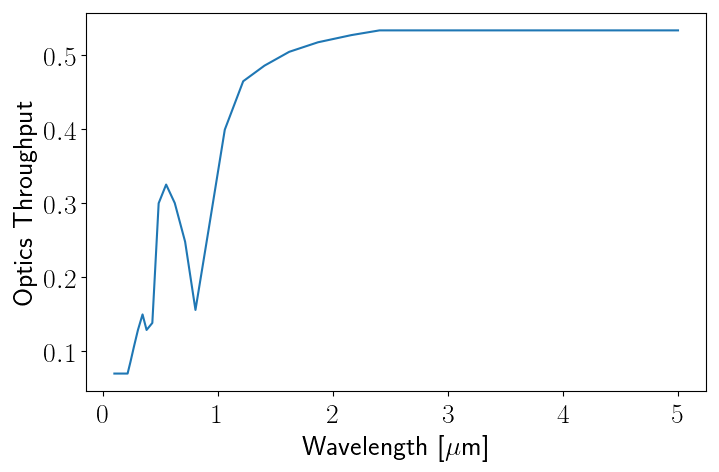

In [33]:
data = np.genfromtxt("../inputs/optical_throughput.txt", skip_header=1)
midlamt = 1e-3 * data[:,2]
Tput_optics = data[:,3]

plt.plot(midlamt, Tput_optics)
plt.xlabel("Wavelength [$\mu$m]")
plt.ylabel("Optics Throughput")

In [34]:
channels = ["UV", "vis", "NIR"]
arch = "A"

luvoir_A = []
for channel in channels:
    luvoir_A.append(default_luvoir(architecture = arch, channel = channel))

In [40]:
cn.telescope = default_luvoir(architecture="A", channel="NIR")

In [41]:
cn.run_count_rates(Ahr, lamhr, fstar)

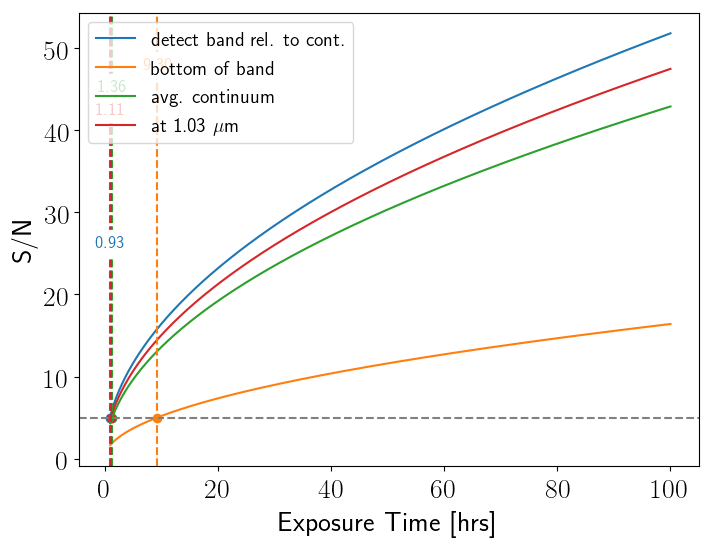

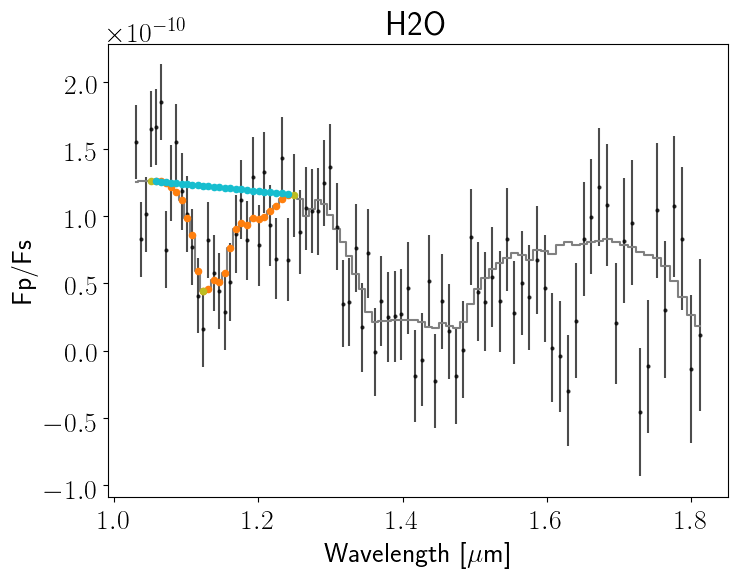

In [42]:
etimes = determine_exposure_time(cn, [1.05, 1.25], title = "H2O", plot_snr_curves=True, plot_spectrum=True, wantSNR=5)

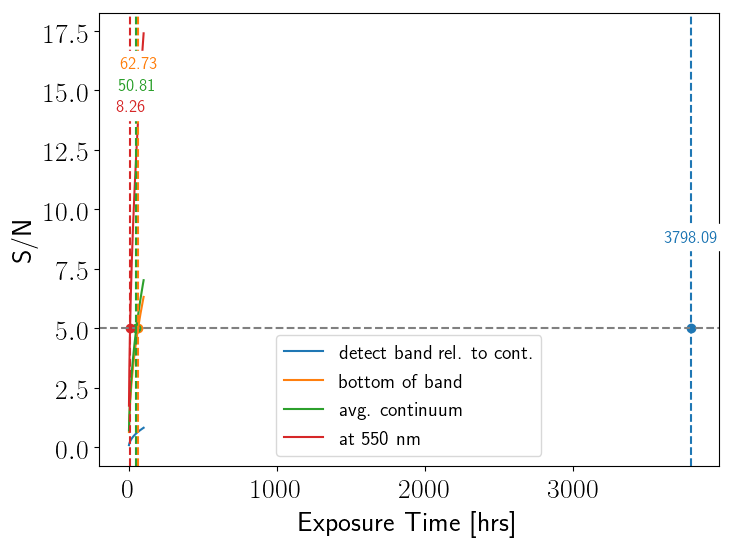

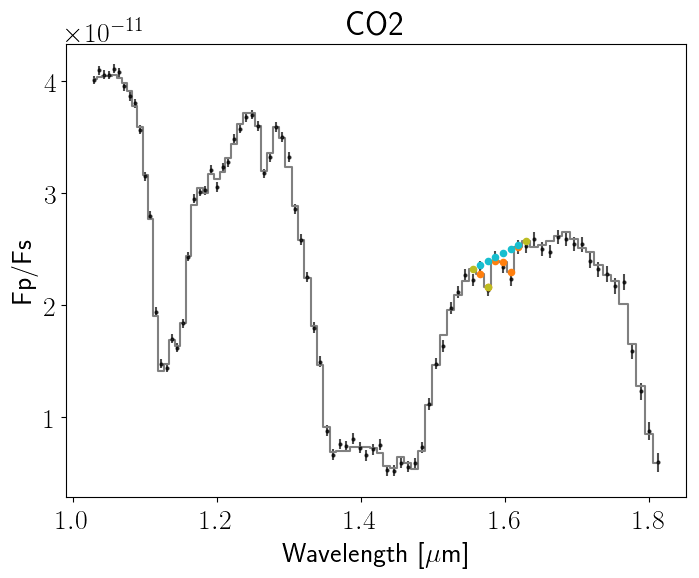

In [552]:
etimes = determine_exposure_time(cn, [1.55, 1.63], title = "CO2", plot_snr_curves=True, plot_spectrum=True, wantSNR=5)

# Determine exposure times for all potential stellar targets  
Can do the random sampling later w/o calling cg model

In [372]:
Ndraw = len(dist)      # Number of stars to calculate for
wantSNR = 5.0

cn.telescope = default_luvoir(architecture="A", channel="vis")

np.random.seed(seed=None)

# Allocate memory for exposure times
ctime_band = np.zeros(Ndraw)
ctime_bot = np.zeros(Ndraw)
ctime_cont = np.zeros(Ndraw)
ctime_fid = np.zeros(Ndraw)
pct_obs_iwa = np.zeros(Ndraw)
lammax_obs_iwa = np.zeros(Ndraw)
    
# Randomly draw sample indices
#idraw = np.random.choice(np.arange(len(hip)), size=Ndraw, replace=False)

# Order systems by "detectability"
#idraw = idraw[np.argsort(dist[idraw])]   # Simply distance for now

# Loop over stars in this sample
for i in range(Ndraw):
    #print("HIP %i, %.2f pc, %s " %(hip[i], dist[i], stype[i]))

    # Set system parameters for this star
    cn = prep_ith_star(cn, i)
    
    # Run count rates
    #etimes = determine_exposure_time(cn, [0.88, 1.0], title = "0.96$\mu$m H$_2$O", plot_snr_curves=False, plot_spectrum=False, wantSNR=wantSNR)
    etimes = determine_exposure_time(cn, [0.75, 0.78], title = "0.76$\mu$m O$_2$", plot_snr_curves=False, plot_spectrum=False, wantSNR=wantSNR)
    #etimes = determine_exposure_time(cn, [1.55, 1.63], title = "CO2", plot_snr_curves=False, plot_spectrum=False, wantSNR=wantSNR)
    
    #etime_band, etime_bot, etime_cont, etime_fid = etimes

    # Parse and distribute results
    ctime_band[i] = etimes[0]
    ctime_bot[i] = etimes[1]
    ctime_cont[i] = etimes[2]
    ctime_fid[i] = etimes[3]
    
    # Calculate percent of observable spectrum 
    pct_obs_iwa[i] = float(sum(np.isfinite(cn.Cobs))) / float(len(cn.Cobs))
    
    if pct_obs_iwa[i] > 0.0:
        lammax_obs_iwa[i] = np.max(cn.lam[np.isfinite(cn.Cobs)])
    else:
        lammax_obs_iwa[i] = np.nan
    
#print(ctime_band, ctime_bot, ctime_cont)

/Users/Jake/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:29: RuntimeWarning: divide by zero encountered in double_scalars


In [373]:
incomplete_vis_spectra = (pct_obs_iwa < 1.0)

print("Incomplete Spectra (%i/%i)" %(np.sum(incomplete_vis_spectra), Ndraw))
print("------------------")
for i in np.arange(Ndraw)[incomplete_vis_spectra]:
    print("- HIP %i, %.2f pc, %s " %(hip[i], dist[i], stype[i]))
    imatch = match_stellar_type(stype[i])
    a_in = calc_dist(lums[imatch], calc_seff(temps[imatch], S0_inner, inner_edge))
    a_out = calc_dist(lums[imatch], calc_seff(temps[imatch], S0_outer, outer_edge))
    print("HZ limits : %.2f - %.2f au" %(a_in, a_out))
    a_eeq = np.sqrt(lums[imatch])
    print("Earth-Equivalent Insolation Distance : %.2f au" %a_eeq)
    print("%.2f%% of spectrum is observable (lam max = %.2f)" %(100.*pct_obs_iwa[i], lammax_obs_iwa[i]))

Incomplete Spectra (6/58)
------------------
- HIP 84720, 8.80 pc, M0V 
HZ limits : 0.38 - 0.72 au
Earth-Equivalent Insolation Distance : 0.35 au
56.36% of spectrum is observable (lam max = 0.75)
- HIP 82588, 16.74 pc, G8V 
HZ limits : 0.82 - 1.46 au
Earth-Equivalent Insolation Distance : 0.81 au
80.91% of spectrum is observable (lam max = 0.90)
- HIP 57507, 17.76 pc, G5V 
HZ limits : 0.92 - 1.61 au
Earth-Equivalent Insolation Distance : 0.92 au
90.91% of spectrum is observable (lam max = 0.97)
- HIP 69972, 11.82 pc, K3V 
HZ limits : 0.60 - 1.10 au
Earth-Equivalent Insolation Distance : 0.58 au
83.64% of spectrum is observable (lam max = 0.92)
- HIP 116085, 16.87 pc, K2V 
HZ limits : 0.66 - 1.19 au
Earth-Equivalent Insolation Distance : 0.63 au
47.27% of spectrum is observable (lam max = 0.70)
- HIP 96895, 21.29 pc, G2V 
HZ limits : 1.10 - 1.89 au
Earth-Equivalent Insolation Distance : 1.11 au
91.82% of spectrum is observable (lam max = 0.97)


3.51 hours to detect band with SNR = 5.0
- HIP 91772, 3.49 pc, K5 
No exact match found
Using K5V for K5
HZ limits : 0.54 - 1.01 au
Earth-Equivalent Insolation Distance : 0.52 au
100.00% of spectrum is observable (lam max = 1.03)


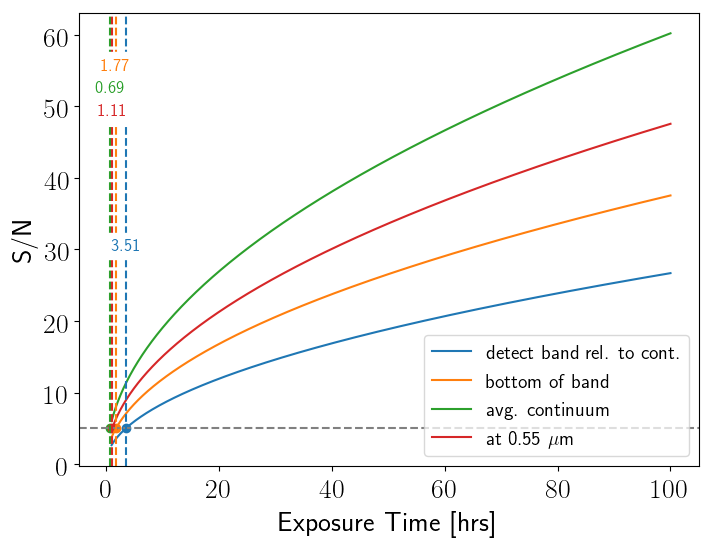

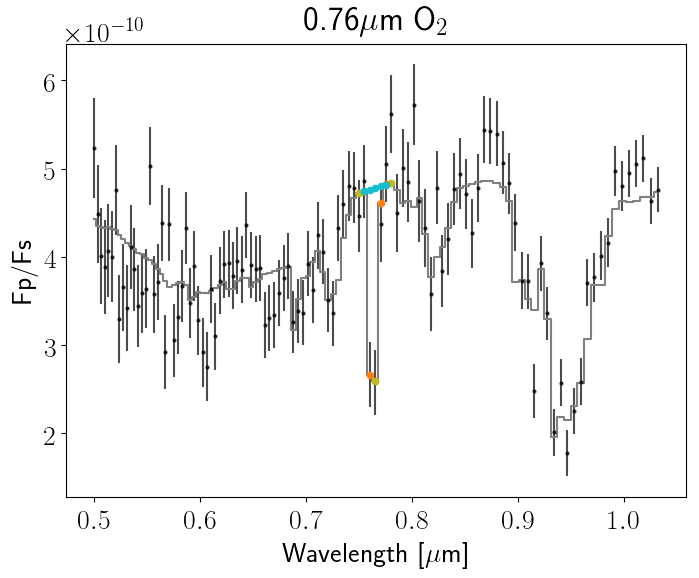

In [374]:
i = np.nanargmin(ctime_band)
print("%.2f hours to detect band with SNR = %.1f" %(ctime_band[i], wantSNR))
print("- HIP %i, %.2f pc, %s " %(hip[i], dist[i], stype[i]))
imatch = match_stellar_type(stype[i])
a_in = calc_dist(lums[imatch], calc_seff(temps[imatch], S0_inner, inner_edge))
a_out = calc_dist(lums[imatch], calc_seff(temps[imatch], S0_outer, outer_edge))
print("HZ limits : %.2f - %.2f au" %(a_in, a_out))
a_eeq = np.sqrt(lums[imatch])
print("Earth-Equivalent Insolation Distance : %.2f au" %a_eeq)
print("%.2f%% of spectrum is observable (lam max = %.2f)" %(100.*pct_obs_iwa[i], lammax_obs_iwa[i]))

cn = prep_ith_star(cn, i)
etimes = determine_exposure_time(cn, [0.75, 0.78], title = "0.76$\mu$m O$_2$", plot_snr_curves=True, plot_spectrum=True, wantSNR=wantSNR)

In [375]:
cn.telescope.resolution

150.0

(1.16463377929332, 0.3460664853638129)


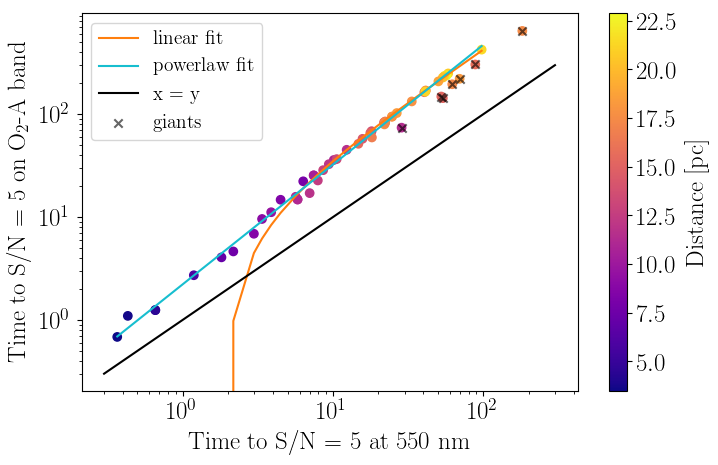

In [727]:
from jakely import colorize

# Calculate stellar distances
rs = np.array([rads[match_stellar_type(s, verbose=False)] for s in stype])

# Color by stellar radius (explains two trends)
vals = np.array([rads[match_stellar_type(s, verbose=False)] for s in stype]); colorlabel = "Stellar Radius"

# Color by stellar distance (helps explain non-linearity for shortest exposures)
vals = dist; colorlabel = "Distance [pc]"

# Color by stellar temperature (helps explain non-linearity for shortest exposures)
#vals = np.array([temps[match_stellar_type(s, verbose=False)] for s in stype]); colorlabel = "Stellar Temperature [K]"

vcolors = colorize(vals)
colors = vcolors[0]

m = rs < 5.0

s = plt.scatter(ctime_fid[m], ctime_band[m], c=vals[m], cmap="plasma")

plt.xlabel("Time to S/N = 5 at 550 nm")
plt.ylabel("Time to S/N = 5 on O$_2$-A band")
plt.colorbar(s, label = colorlabel)

cutval = 2.0
m = rs >= cutval

s = plt.scatter(ctime_fid[m], ctime_band[m], c = "k", marker="x", alpha = 0.6, label = "giants")

m = (rs < cutval) & (np.isfinite(ctime_band))

# Fit a line 
x = ctime_fid[m]
y = ctime_band[m]
isort = np.argsort(x)
x, y = x[isort], y[isort]
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
y_fit = slope * x + intercept
#print(slope, intercept)
plt.plot(x, y_fit, c = "C1", label = "linear fit")

# Fit a line in log-log space
x = ctime_fid[m]
y = ctime_band[m]
isort = np.argsort(x)
x, y = np.log10(x[isort]), np.log10(y[isort])
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
y_fit = slope * x + intercept
print(slope, intercept)
plt.plot(10**x, 10**y_fit, c = "C9", label = "powerlaw fit")

plt.plot(np.linspace(0.3, .3e3), np.linspace(0.3, .3e3), c = "k", label = "x = y")

#xf = np.linspace(0.3, .3e3)
#yf = (10.**intercept) * xf**slope
#plt.plot(xf, yf, color = "C1")

plt.legend(fontsize = 14)

plt.xscale("log")
plt.yscale("log")

In [833]:
Ndraw = len(dist)      # Number of stars to calculate for
wantSNR = 5.0

cn.telescope = default_luvoir(architecture="A", channel="NIR")

np.random.seed(seed=None)

# Allocate memory for exposure times
ctime_band = np.zeros(Ndraw)
ctime_bot = np.zeros(Ndraw)
ctime_cont = np.zeros(Ndraw)
ctime_fid = np.zeros(Ndraw)
pct_obs_iwa = np.zeros(Ndraw)
lammax_obs_iwa = np.zeros(Ndraw)
    
# Randomly draw sample indices
#idraw = np.random.choice(np.arange(len(hip)), size=Ndraw, replace=False)

# Order systems by "detectability"
#idraw = idraw[np.argsort(dist[idraw])]   # Simply distance for now

# Loop over stars in this sample
for i in range(Ndraw):
    #print("HIP %i, %.2f pc, %s " %(hip[i], dist[i], stype[i]))

    # Set system parameters for this star
    cn = prep_ith_star(cn, i)
    
    # Run count rates
    #etimes = determine_exposure_time(cn, [0.88, 1.0], title = "0.96$\mu$m H$_2$O", plot_snr_curves=False, plot_spectrum=False, wantSNR=wantSNR)
    #etimes = determine_exposure_time(cn, [0.75, 0.78], title = "0.76$\mu$m O$_2$", plot_snr_curves=False, plot_spectrum=False, wantSNR=wantSNR)
    etimes = determine_exposure_time(cn, [1.55, 1.63], title = "CO2", plot_snr_curves=False, plot_spectrum=False, wantSNR=wantSNR)
    
    #etime_band, etime_bot, etime_cont, etime_fid = etimes

    # Parse and distribute results
    ctime_band[i] = etimes[0]
    ctime_bot[i] = etimes[1]
    ctime_cont[i] = etimes[2]
    ctime_fid[i] = etimes[3]
    
    # Calculate percent of observable spectrum 
    pct_obs_iwa[i] = float(sum(np.isfinite(cn.Cobs))) / float(len(cn.Cobs))
    
    if pct_obs_iwa[i] > 0.0:
        lammax_obs_iwa[i] = np.max(cn.lam[np.isfinite(cn.Cobs)])
    else:
        lammax_obs_iwa[i] = np.nan
    
#print(ctime_band, ctime_bot, ctime_cont)

/Users/Jake/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:29: RuntimeWarning: divide by zero encountered in double_scalars


In [834]:
incomplete_vis_spectra = (pct_obs_iwa < 1.0)

print("Incomplete Spectra (%i/%i)" %(np.sum(incomplete_vis_spectra), Ndraw))
print("------------------")
for i in np.arange(Ndraw)[incomplete_vis_spectra]:
    print("- HIP %i, %.2f pc, %s " %(hip[i], dist[i], stype[i]))
    imatch = match_stellar_type(stype[i])
    a_in = calc_dist(lums[imatch], calc_seff(temps[imatch], S0_inner, inner_edge))
    a_out = calc_dist(lums[imatch], calc_seff(temps[imatch], S0_outer, outer_edge))
    print("HZ limits : %.2f - %.2f au" %(a_in, a_out))
    a_eeq = np.sqrt(lums[imatch])
    print("Earth-Equivalent Insolation Distance : %.2f au" %a_eeq)
    print("%.2f%% of spectrum is observable (lam max = %.2f)" %(100.*pct_obs_iwa[i], lammax_obs_iwa[i]))

Incomplete Spectra (17/58)
------------------
- HIP 84720, 8.80 pc, M0V 
HZ limits : 0.38 - 0.72 au
Earth-Equivalent Insolation Distance : 0.35 au
11.63% of spectrum is observable (lam max = 1.09)
- HIP 42808, 11.18 pc, K2V 
HZ limits : 0.66 - 1.19 au
Earth-Equivalent Insolation Distance : 0.63 au
70.93% of spectrum is observable (lam max = 1.53)
- HIP 40693, 12.49 pc, K0V 
HZ limits : 0.76 - 1.36 au
Earth-Equivalent Insolation Distance : 0.74 au
79.07% of spectrum is observable (lam max = 1.61)
- HIP 82588, 16.74 pc, G8V 
HZ limits : 0.82 - 1.46 au
Earth-Equivalent Insolation Distance : 0.81 au
43.02% of spectrum is observable (lam max = 1.31)
- HIP 42808, 11.18 pc, K2V 
HZ limits : 0.66 - 1.19 au
Earth-Equivalent Insolation Distance : 0.63 au
70.93% of spectrum is observable (lam max = 1.53)
- HIP 57507, 17.76 pc, G5V 
HZ limits : 0.92 - 1.61 au
Earth-Equivalent Insolation Distance : 0.92 au
55.81% of spectrum is observable (lam max = 1.41)
- HIP 69972, 11.82 pc, K3V 
HZ limits : 0.6

75.15 hours to detect band with SNR = 5.0
- HIP 91772, 3.49 pc, K5 
No exact match found
Using K5V for K5
HZ limits : 0.54 - 1.01 au
Earth-Equivalent Insolation Distance : 0.52 au
100.00% of spectrum is observable (lam max = 1.81)


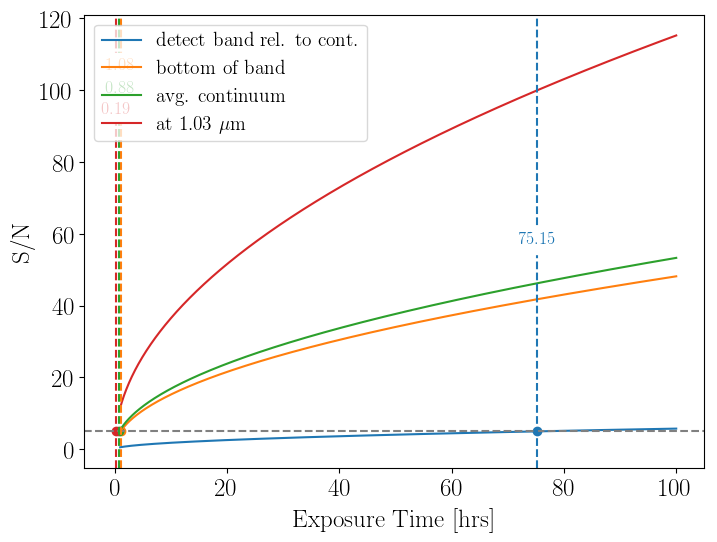

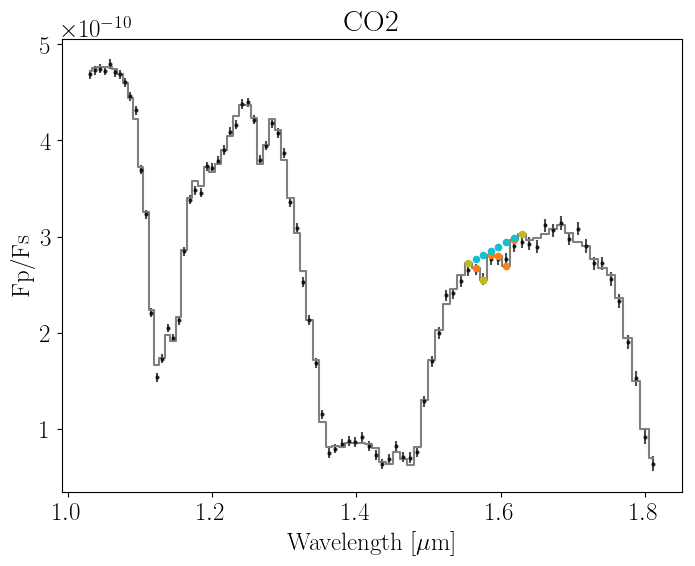

In [835]:
i = np.nanargmin(ctime_band)
print("%.2f hours to detect band with SNR = %.1f" %(ctime_band[i], wantSNR))
print("- HIP %i, %.2f pc, %s " %(hip[i], dist[i], stype[i]))
imatch = match_stellar_type(stype[i])
a_in = calc_dist(lums[imatch], calc_seff(temps[imatch], S0_inner, inner_edge))
a_out = calc_dist(lums[imatch], calc_seff(temps[imatch], S0_outer, outer_edge))
print("HZ limits : %.2f - %.2f au" %(a_in, a_out))
a_eeq = np.sqrt(lums[imatch])
print("Earth-Equivalent Insolation Distance : %.2f au" %a_eeq)
print("%.2f%% of spectrum is observable (lam max = %.2f)" %(100.*pct_obs_iwa[i], lammax_obs_iwa[i]))

cn = prep_ith_star(cn, i)
etimes = determine_exposure_time(cn, [1.55, 1.63], title = "CO2", plot_snr_curves=True, plot_spectrum=True, wantSNR=wantSNR)

In [836]:
etimes

(75.14501664805833,
 1.0781340413227902,
 0.8805431617926255,
 0.18842692001049544)

In [734]:
cn.make_fake_data(texp = 75.)

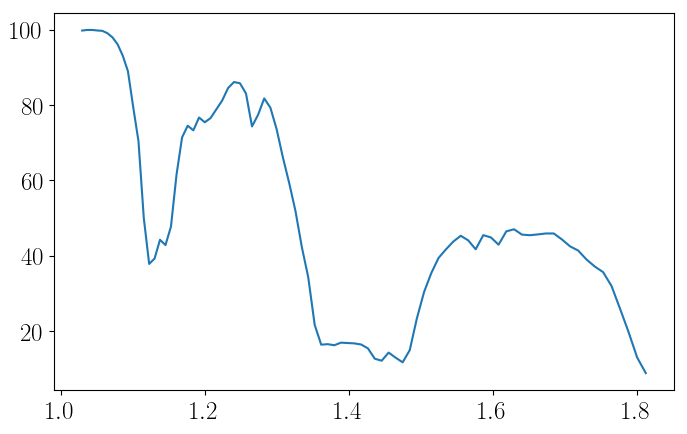

In [737]:
plt.plot(cn.lam, cn.SNRt)

In [744]:
fn = 'Hazy_ArcheanEarth_geo_albedo.txt'
model = np.loadtxt(os.path.join("../inputs/",fn))
lamhr_arch = model[:,0]
Ahr_arch   = model[:,1]
Fs_arch = model[:,2]

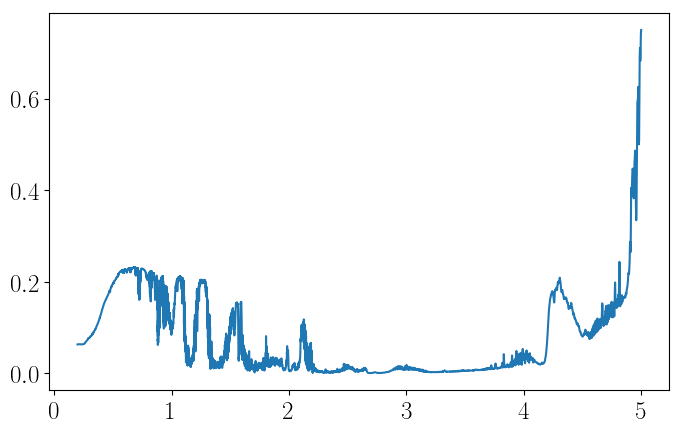

In [746]:
plt.plot(lamhr_arch, Ahr_arch)

In [748]:
cn.telescope.lammax

1.8

In [35]:
bandwidth = 0.2
R = 1.0 / bandwidth
lam, dlam = cg.noise_routines.construct_lam(1.03, 1.8, Res = R)

In [773]:
left = lam
right = lam + 1.0*dlam
center = lam + 0.5*dlam

In [36]:
def calculate_bandpass_edges(lammin, lammax, bandwidth = 0.2):
    """
    """
    
    edge = lammin
    edges = []

    edges.append(edge)
    while edge < lammax:
        edge += bandwidth*edge
        edges.append(edge)
        
    edges[-1] = lammax
    
    edges = np.array(edges)
    
    return edges

In [37]:
edges = calculate_bandpass_edges(1.03, 1.8, bandwidth = 0.2)

In [38]:
Nbands = len(edges) - 1

for i in range(Nbands):
    lammin = edges[i]
    lammax = edges[i+1]
    lammid = 0.5*(lammax + lammin)
    print(lammin, lammid, lammax)


(1.03, 1.133, 1.236)
(1.236, 1.3596, 1.4832)
(1.4832, 1.63152, 1.77984)
(1.77984, 1.78992, 1.8)


**Perform calculations on a flat spectrum to avoid the long exposures needed for a fixed SNR at the bottom of bands**

0.16181260211198994


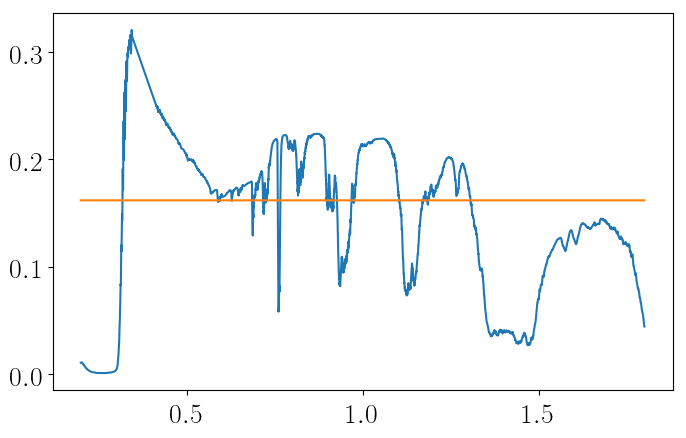

In [39]:
lammin = 0.2
lammax = 1.8
m = (lamhr > lammin) & (lamhr < lammax)

plt.plot(lamhr[m], Ahr[m])

Ahr_flat = np.median(Ahr[m]) * np.ones(len(Ahr))
#Ahr_flat = 0.2 * np.ones(len(Ahr))

plt.plot(lamhr[m], Ahr_flat[m])

print(np.median(Ahr[m]))

('UV', 0.2, 0.5)
(0.22000000000000003, 2890.045274051289)
(0.264, 121.46175775830001)
(0.3168, 5.217218790854025)
(0.38016000000000005, 2.780858131058683)


/Users/Jake/Projects/coronagraph/coronagraph/count_rates.py:281: RuntimeWarning: divide by zero encountered in true_divide
  Csig = self.Cratio/SNRt
/Users/Jake/Projects/coronagraph/coronagraph/count_rates.py:282: RuntimeWarning: divide by zero encountered in true_divide
  Asig = self.A/SNRt
/Users/Jake/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:3236: RuntimeWarning: invalid value encountered in double_scalars
  in cbook.safezip(data, err)]


(0.45619200000000004, 0.4570797234805274)
(0.49883200000000005, 0.27144962823203633)
('vis', 0.5, 1.03)
(0.55, 3.5310958203298592)
(0.6599999999999999, 3.824726634971623)
(0.792, 5.798725276443237)
(0.9470000000000001, 3.196113859458034)
('NIR', 1.03, 1.8)
(1.133, 9.0700343509238)
(1.3596, 11.04911698903473)
(1.63152, 15.497148770288103)
(1.78992, 25.36883251440113)


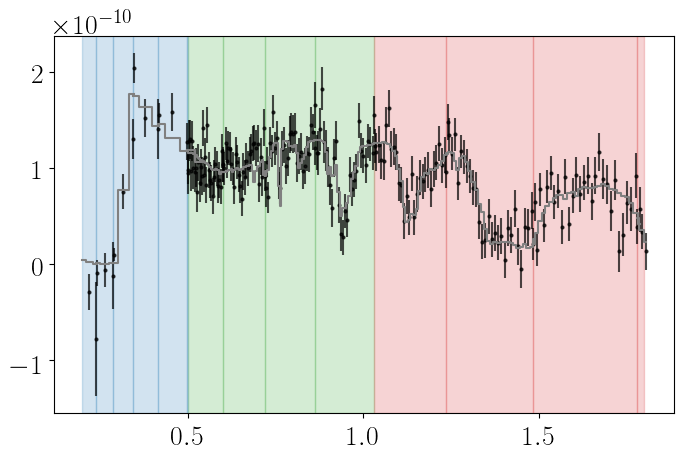

In [40]:
fig, ax = plt.subplots()
cc = ["C0", "C2", "C3"]
wantSNR = 5.0
t_chan = np.zeros(len(channels))

# Loop over telescope channels
for j, channel in enumerate(channels):
    
    # Get the channel specific telescope parameters
    luvoir = default_luvoir(channel=channel)
    
    print(channel, luvoir.lammin, luvoir.lammax)
    
    # Calculate the bandpass edges
    edges = calculate_bandpass_edges(luvoir.lammin, luvoir.lammax, bandwidth = 0.2)
    
    # Calculate the number of bandpasses
    Nbands = len(edges) - 1
    
    # Loop over bandpasses
    for i in range(Nbands):
        
        # Get the max, min, and middle wavelenths for this bandpass
        lammin = edges[i]
        lammax = edges[i+1]
        lammid = 0.5*(lammax + lammin)
        
        # Set telescope wavelength range
        luvoir.lammin = lammin
        luvoir.lammax = lammax
        cn.telescope = luvoir
        
        # Run count rates (necessary to generate new wavelength grid)
        cn.run_count_rates(Ahr_flat, lamhr, fstar)
        
        # Calculate exposure times to wantSNR
        etimes = determine_exposure_time(cn, None, plot_snr_curves=False, plot_spectrum=False, wantSNR=wantSNR, ref_lam = lammid)
        t_ref_lam = etimes[-1]
        
        # Re-do count rate calcs for true Earth spectrum
        cn.run_count_rates(Ahr, lamhr, fstar)
        
        # Draw random samples of data for a plot
        cn.make_fake_data(texp=t_ref_lam)
        
        print(lammid, t_ref_lam)
        
        # Plot
        ax.axvspan(lammin, lammax, alpha = 0.2, color = cc[j])
        ax.plot(cn.lam, cn.Cratio, ls = "steps-mid", color = "grey", zorder = 100)
        ax.errorbar(cn.lam, cn.Cobs, yerr=cn.Csig, fmt = "o", ms = 2.0, alpha = 0.7, color = "k")
        
        # Save values
        t_chan[j] += t_ref_lam
        
#xlims = ax.get_xlim()
#ax.plot(lamhr, Ahr, c = "k")
#ax.set_xlim(xlims)
#ax.set_ylim(0,1)

In [93]:
t_chan

array([3020.23363808,   16.35066159,   60.98513262])

In [94]:
t_chan

array([3020.23363808,   16.35066159,   60.98513262])

In [43]:
# Deal with the "two channels at a time" thing

# Sort the exposure times
isort = np.argsort(t_chan)

# Find channel that requires the longest exposure time
imax = isort[-1]

# Record longest time
t_long = t_chan[imax] 

# Record sum of the other two channels
t_sum = (np.sum(t_chan) - t_chan[imax])

if t_long > t_sum:
    t_tot = t_long
else:
    t_tot = t_sum

In [44]:
t_tot

3020.2336380832144

In [45]:
def calc_observable_spectrum(cn):
    """
    Calculate the percentage of the spectrum observable, considering IWA and OWA
    """
    
    # Calculate percent of observable spectrum 
    pct_obs_iwa = float(sum(np.isfinite(cn.Cobs))) / float(len(cn.Cobs))
    
    if pct_obs_iwa > 0.0:
        lammax_obs_iwa = np.max(cn.lam[np.isfinite(cn.Cobs)])
    else:
        lammax_obs_iwa = np.nan
        
    return pct_obs_iwa, lammax_obs_iwa

def apply_two_channels(t_chan):
    """
    Deal with the "two channels at a time" thing
    """

    # Sort the exposure times
    isort = np.argsort(t_chan)

    # Find channel that requires the longest exposure time
    imax = isort[-1]

    # Record longest time
    t_long = t_chan[imax] 

    # Record sum of the other two channels
    t_sum = (np.sum(t_chan) - t_chan[imax])

    # Logic for deciding total exposure time
    if t_long > t_sum:
        # if the longest exposure channel is longer than the other two combined
        # then they can both be observed during t_long
        t_tot = t_long
    else:
        # Otherwise the t_long can be observed while the during both the second and third
        # longest exposure time channels
        t_tot = t_sum
        
    return t_tot

def complete_spectrum_time(cn, Ahr_flat = 0.1618, wantSNR = 5.0, plot = False, verbose = False):
    """
    Time for a complete spectrum
    
    Parameters
    ----------
    Ahr_flat : float
        Flat albedo spectrum (default is the median Earth spectrum between 0.2 - 1.8 µm)
    """
    
    if plot: fig, ax = plt.subplots()
    
    cc = ["C0", "C2", "C3"]
    t_chan = np.zeros(len(channels))
    Nbands_per_chan = np.zeros(len(channels))
    t_per_band_per_chan = []
    full_lam = []
    full_Cobs = []
    full_Cratio = []
    full_Csig = []
    pct_obs_iwa = []
    lammax_obs_iwa = []

    # Loop over telescope channels
    for j, channel in enumerate(channels):
        
        t_tmp = []

        # Get the channel specific telescope parameters
        luvoir = default_luvoir(channel=channel)
        cn.telescope = luvoir

        if verbose: print(channel, luvoir.lammin, luvoir.lammax)

        # Calculate the bandpass edges
        edges = calculate_bandpass_edges(luvoir.lammin, luvoir.lammax, bandwidth = 0.2)

        # Calculate the number of bandpasses
        Nbands = len(edges) - 1
        Nbands_per_chan[j] = Nbands
        
        # Run count rates (necessary to generate new wavelength grid)
        cn.run_count_rates(Ahr, lamhr, fstar)
        
        # Calculate how much of the spectrum is observable
        pct, lammax_obs = calc_observable_spectrum(cn)
        pct_obs_iwa.append(pct) 
        lammax_obs_iwa.append(lammax_obs)

        # Loop over bandpasses
        for i in range(Nbands):

            # Get the max, min, and middle wavelenths for this bandpass
            lammin = edges[i]
            lammax = edges[i+1]
            lammid = 0.5*(lammax + lammin)

            # Set telescope wavelength range
            cn.telescope.lammin = lammin
            cn.telescope.lammax = lammax
            
            # Set spectrum to use for exposure time calcs
            # Using flat spectrum so not biased by bottom of bands
            Ahr_flat  = Ahr_flat * np.ones(len(lamhr))

            # Run count rates (necessary to generate new wavelength grid)
            cn.run_count_rates(Ahr_flat, lamhr, fstar)

            # Calculate exposure times to wantSNR
            etimes = determine_exposure_time(cn, None, plot_snr_curves=False, plot_spectrum=False, wantSNR=wantSNR, ref_lam = lammid)
            t_ref_lam = etimes[-1]

            # Re-do count rate calcs for true Earth spectrum
            cn.run_count_rates(Ahr, lamhr, fstar)

            # Draw random samples of data for a plot
            cn.make_fake_data(texp=t_ref_lam)

            if verbose: print(lammid, t_ref_lam)

            # Plot
            if plot:
                ax.axvspan(lammin, lammax, alpha = 0.2, color = cc[j])
                ax.plot(cn.lam, cn.Cratio, ls = "steps-mid", color = "grey", zorder = 100)
                ax.errorbar(cn.lam, cn.Cobs, yerr=cn.Csig, fmt = "o", ms = 2.0, alpha = 0.7, color = "k")
                ax.set_xlabel("Wavelength [$\mu$m]")
                ax.set_ylabel("$F_p / F_s$")

            # Save values
            t_tmp.append(t_ref_lam)
            full_lam.append(cn.lam)
            full_Cratio.append(cn.Cratio)
            full_Cobs.append(cn.Cobs)
            full_Csig.append(cn.Csig)
            
            # Add time
            if np.isfinite(t_ref_lam):
                t_chan[j] += t_ref_lam
            
        # Save tmp times per band
        t_per_band_per_chan.append(t_tmp)
    
    # Deal with the "two channels at a time" thing
    t_tot = apply_two_channels(t_chan)
    
    spectrum = (np.array(full_lam), np.array(full_Cratio), np.array(full_Cobs), np.array(full_Csig))
    iwa = (pct_obs_iwa, lammax_obs_iwa)
        
    return t_tot, t_per_band_per_chan, spectrum, iwa

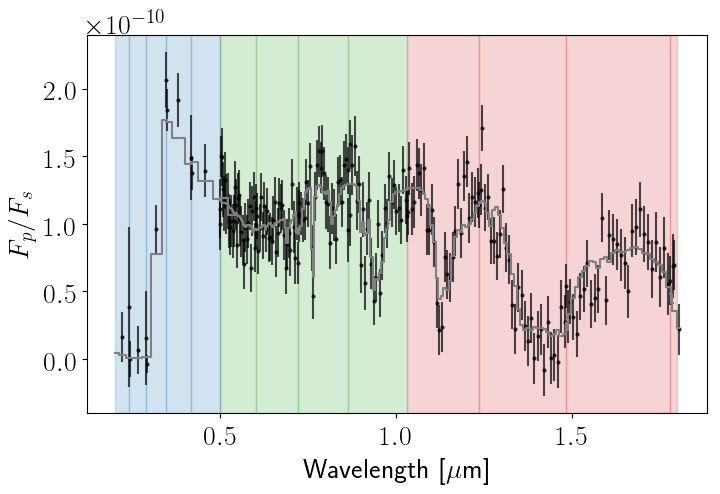

In [46]:
t_tot, tpbpc, spectrum, iwa = complete_spectrum_time(cn, plot=True)

In [47]:
iwa

([0.9090909090909091, 1.0, 1.0],
 [0.51874849202, 1.031596885346276, 1.8118436777255387])

In [48]:
np.sum(tpbpc[2])

60.994478484889456

In [49]:
t_tot

3020.697465292147

<ErrorbarContainer object of 3 artists>

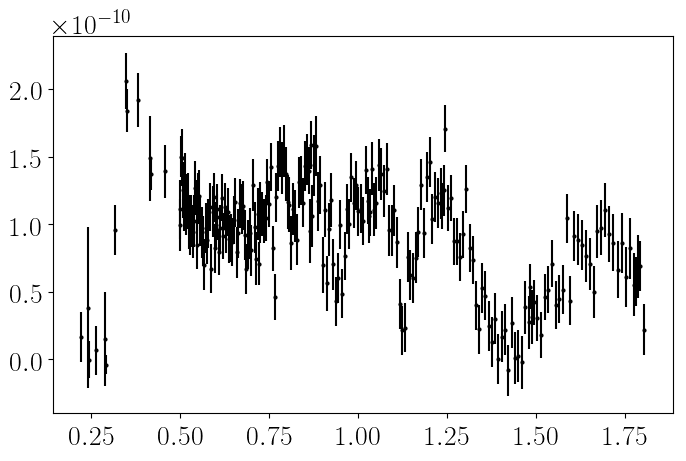

In [50]:
plt.errorbar(np.hstack(spectrum[0]), np.hstack(spectrum[2]), yerr=np.hstack(spectrum[3]), fmt = "ko", ms = 2 )

In [51]:
t_tot

3020.697465292147

In [209]:
Ndraw = len(dist)      # Number of stars to calculate for
wantSNR = 5.0

np.random.seed(seed=None)

# Allocate memory for exposure times
t_tots = np.zeros(Ndraw)
tpbpcs = []
pct_obs_iwas = []
lammax_obs_iwas = []
specs = []
    
# Randomly draw sample indices
#idraw = np.random.choice(np.arange(len(hip)), size=Ndraw, replace=False)

# Order systems by "detectability"
#idraw = idraw[np.argsort(dist[idraw])]   # Simply distance for now

# Loop over stars in this sample
for i in range(Ndraw):
    #print("HIP %i, %.2f pc, %s " %(hip[i], dist[i], stype[i]))

    # Set system parameters for this star
    cn = prep_ith_star(cn, i)
    
    # Calculate the time to observe the complete spectrum
    t_tots[i], tpbpc, spectrum, iwa = complete_spectrum_time(cn, plot=False) 
    
    tpbpcs.append(tpbpc)
    pct_obs_iwas.append(iwa[0])
    specs.append(spectrum)

#print(ctime_band, ctime_bot, ctime_cont)

/Users/Jake/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:29: RuntimeWarning: divide by zero encountered in double_scalars


In [210]:
isort = np.argsort(t_tots)
t_tots[isort]

array([3.04139928e+01, 4.83911831e+02, 1.32504052e+03, 1.32504052e+03,
       1.63812894e+03, 2.40314194e+03, 4.04796069e+03, 8.02450321e+03,
       9.00172143e+03, 1.00494360e+04, 1.71906478e+04, 1.77798578e+04,
       2.12288887e+04, 2.25274642e+04, 2.26704301e+04, 2.63520840e+04,
       4.49244041e+04, 4.64444715e+04, 4.64444715e+04, 4.81420170e+04,
       4.81420170e+04, 5.77282529e+04, 6.57294844e+04, 7.27346960e+04,
       7.30994217e+04, 8.26834415e+04, 8.78162812e+04, 9.98972687e+04,
       1.45631543e+05, 1.50807949e+05, 1.73229967e+05, 1.76265401e+05,
       1.82886286e+05, 1.98196639e+05, 1.98940352e+05, 2.24517906e+05,
       2.33569814e+05, 2.38343864e+05, 2.76650886e+05, 2.82809259e+05,
       2.82809259e+05, 3.00265825e+05, 3.21120937e+05, 3.21120937e+05,
       3.41685304e+05, 3.54131398e+05, 3.63618458e+05, 3.73136374e+05,
       4.06771927e+05, 4.40137576e+05, 4.40701490e+05, 5.31355128e+05,
       6.29100878e+05, 6.31457412e+05, 7.06638841e+05, 7.13345636e+05,
      

In [211]:
deltas = []
for channel in channels:
    l = default_luvoir(channel=channel)
    deltas.append(l.lammax - l.lammin)
deltas = np.array(deltas)

In [212]:
channel_weights = (deltas / np.sum(deltas))

In [213]:
completeness = np.sum(np.array(pct_obs_iwas) * channel_weights, axis = 1)
completeness

array([0.96590909, 0.96590909, 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 0.37420455, 0.8125    ,
       1.        , 1.        , 0.93181818, 1.        , 1.        ,
       0.86010174, 0.8125    , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 0.96590909, 0.89927326,
       0.8125    , 1.        , 0.45551136, 0.8125    , 0.86010174,
       0.56974101, 0.27704545, 0.8125    , 0.93284884, 0.75094477,
       0.15659091, 0.8125    , 1.        , 0.76584831, 0.8125    ,
       1.        , 1.        , 0.8712936 , 0.8125    , 0.89927326,
       0.8125    , 0.91606105, 0.8125    , 1.        , 1.        ,
       0.93844477, 0.74534884, 0.8125    , 1.        , 0.97202035,
       0.8125    , 1.        , 1.        ])

In [214]:
# Spectral Characterization Index (SCI)
sci = t_tots / completeness

In [215]:
isort = np.argsort(sci)

In [216]:
t_tots[isort]

array([3.04139928e+01, 4.83911831e+02, 1.32504052e+03, 1.32504052e+03,
       1.63812894e+03, 2.40314194e+03, 4.04796069e+03, 8.02450321e+03,
       9.00172143e+03, 1.00494360e+04, 1.71906478e+04, 2.25274642e+04,
       2.12288887e+04, 2.26704301e+04, 2.63520840e+04, 4.49244041e+04,
       1.77798578e+04, 4.81420170e+04, 4.81420170e+04, 4.64444715e+04,
       4.64444715e+04, 6.57294844e+04, 7.27346960e+04, 8.78162812e+04,
       7.30994217e+04, 9.98972687e+04, 8.26834415e+04, 1.50807949e+05,
       1.73229967e+05, 1.45631543e+05, 1.82886286e+05, 1.76265401e+05,
       1.98196639e+05, 1.98940352e+05, 5.77282529e+04, 2.24517906e+05,
       2.76650886e+05, 2.82809259e+05, 3.41685304e+05, 3.21120937e+05,
       3.63618458e+05, 2.82809259e+05, 3.54131398e+05, 4.06771927e+05,
       3.21120937e+05, 3.73136374e+05, 2.33569814e+05, 3.00265825e+05,
       5.31355128e+05, 4.40137576e+05, 4.40701490e+05, 7.06638841e+05,
       7.13345636e+05, 6.31457412e+05, 6.29100878e+05, 8.59972789e+05,
      

In [217]:
completeness[isort]

array([0.96590909, 1.        , 1.        , 0.8125    , 0.96590909,
       0.96590909, 1.        , 1.        , 0.93181818, 1.        ,
       1.        , 1.        , 0.8125    , 0.8125    , 0.8125    ,
       1.        , 0.37420455, 1.        , 1.        , 0.86010174,
       0.86010174, 1.        , 0.89927326, 1.        , 0.8125    ,
       1.        , 0.8125    , 1.        , 1.        , 0.8125    ,
       1.        , 0.89927326, 1.        , 1.        , 0.27704545,
       1.        , 0.97202035, 0.93284884, 1.        , 0.93844477,
       1.        , 0.74534884, 0.91606105, 1.        , 0.75094477,
       0.8125    , 0.45551136, 0.56974101, 1.        , 0.8125    ,
       0.8125    , 1.        , 1.        , 0.8125    , 0.76584831,
       0.8712936 , 0.8125    , 0.15659091])

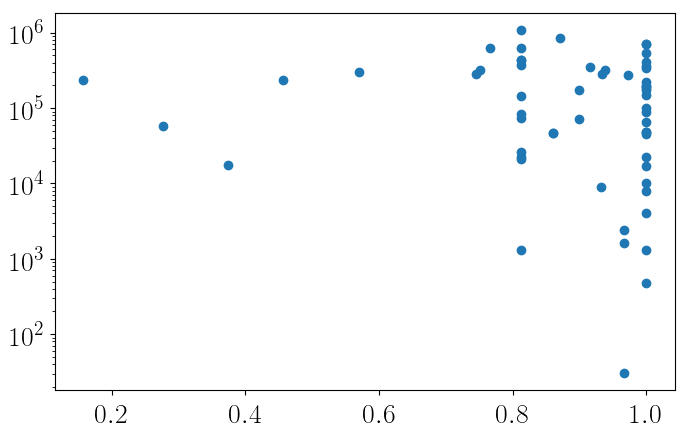

In [179]:
plt.plot(completeness, t_tots, "o")
plt.yscale("log")

In [218]:
# Bandpasses
np.hstack(tpbpcs[0])

array([          inf, 1550.70372636,   55.54180645,   26.21388819,
          3.60881742,    2.06069672,   25.51969013,   26.05853786,
         37.32124093,   19.58145972,   59.49218702,   72.56762205,
        102.32446719,  168.59977117])

In [219]:
np.array(pct_obs_iwas)[0] * channel_weights

array([0.15340909, 0.33125   , 0.48125   ])

In [220]:
(specs[0][0][0][-1] - specs[0][0][0][0]) / np.sum(deltas)

0.02624999999999999

In [221]:
# Calculate exposure time derivatives 

Nbs = len(np.hstack(tpbpcs[0]))

dtpb = np.zeros((Ndraw, Nbs))  # Time per band
dcomp = np.zeros((Ndraw, Nbs)) # completeness
dtdc = np.zeros((Ndraw, Nbs))  # d(time) / d(completeness)

for i in range(Ndraw):
    
    # Create array of times per bandpass
    dtpb[i,:] = np.hstack(tpbpcs[i])
    
    for j in range(Nbs):
        
        # Calculate delta completeness: fractional increase in completeness from observing this band
        dcomp[i,j] = (specs[i][0][j][-1] - specs[i][0][j][0]) / np.sum(deltas)
        
# Calculate d(exposure time) / d(completeness) 
dtdc = dtpb / dcomp

In [335]:
def calc_dtdc(tpbpcs, specs):
    """
    Calculate partial derivatives of exposure time wrt completeness for each bandpass 
    
    Parameters
    ----------
    tpbpcs : list 
        Time per bandpass per channel for each star
    """
    
    # Calc wavelength range of channels 
    deltas = []
    for channel in channels:
        l = default_luvoir(channel=channel)
        deltas.append(l.lammax - l.lammin)
    deltas = np.array(deltas)

    Nbs = len(np.hstack(tpbpcs[0]))
    Ndraw = len(tpbpcs)

    dtpb = np.zeros((Ndraw, Nbs))  # Time per band
    dcomp = np.zeros((Ndraw, Nbs)) # completeness
    dtdc = np.zeros((Ndraw, Nbs))  # d(time) / d(completeness)

    for i in range(Ndraw):

        # Create array of times per bandpass
        dtpb[i,:] = np.hstack(tpbpcs[i])

        for j in range(Nbs):

            # Calculate delta completeness: fractional increase in completeness from observing this band
            dcomp[i,j] = (specs[i][0][j][-1] - specs[i][0][j][0]) / np.sum(deltas)

    # Calculate d(exposure time) / d(completeness) 
    dtdc = dtpb / dcomp
    
    return dtpb, dcomp, dtdc

def calc_dtdc_star(tpbpc0, spec):
    """
    Calculate partial derivatives of exposure time wrt completeness for each bandpass 
    
    Parameters
    ----------
    tpbpc : list 
        Time per bandpass per channel
    """
    
    # Calc wavelength range of channels 
    deltas = []
    for channel in channels:
        l = default_luvoir(channel=channel)
        deltas.append(l.lammax - l.lammin)
    deltas = np.array(deltas)
    
    # Create array of times per bandpass
    dtpb = np.hstack(tpbpc0)

    Nbs = len(dtpb)

    dcomp = np.zeros(Nbs) # completeness
    dtdc = np.zeros(Nbs)  # d(time) / d(completeness)

    for j in range(Nbs):

        # Calculate delta completeness: fractional increase in completeness from observing this band
        dcomp[j] = (spec[0][j][-1] - spec[0][j][0]) / np.sum(deltas)

    # Calculate d(exposure time) / d(completeness) 
    dtdc = dtpb / dcomp
    
    return dtpb, dcomp, dtdc

In [223]:
dtpb, dcomp, dtdc = calc_dtdc(tpbpcs, specs)

In [224]:
dtdc[0] 

array([           inf, 49228.68972565,  1469.35995908,   577.90758798,
          66.29955575,    66.25182361,   399.37091909,   339.83635654,
         405.5968977 ,   184.53697361,   451.95350128,   459.40473458,
         539.82229913, 11329.53337622])

In [294]:
calc_dtdc_star(tpbpcs[0], specs[0])[-1]

array([           inf, 49228.68972565,  1469.35995908,   577.90758798,
          66.29955575,    66.25182361,   399.37091909,   339.83635654,
         405.5968977 ,   184.53697361,   451.95350128,   459.40473458,
         539.82229913, 11329.53337622])

In [225]:
new_completeness = np.zeros_like(completeness)
new_t_tots = np.zeros_like(t_tots)
maxderivs = np.zeros_like(t_tots)

for i in range(len(dist)):
    
    print("-- original: %.3f%% completeness in %.2f hours" %(completeness[i]*100, t_tots[i]))

    maxderiv = np.max(dtdc[i][np.isfinite(dtdc[i])])
    imax = np.argmin(np.fabs(dtdc[i] - maxderiv))
    maxderivs[i] = maxderiv

    print("but it takes %.2f hours just to add %.3f%% completeness (%.2f - %.2f µm)" %(dtpb[i,imax], 100*dcomp[i,imax], specs[0][0][imax][0], specs[0][0][imax][-1]))

    modcomp = completeness[i] - dcomp[i,imax]
    modtime = t_tots[i] - dtpb[i,imax]
    
    new_completeness[i] = modcomp
    new_t_tots[i] = modtime

    print("1 step down: %.3f%% completeness in %.2f hours" %(modcomp*100, modtime))

-- original: 96.591% completeness in 1638.13 hours
but it takes 1550.70 hours just to add 3.150% completeness (0.24 - 0.29 µm)
1 step down: 93.441% completeness in 87.43 hours
-- original: 96.591% completeness in 30.41 hours
but it takes 27.81 hours just to add 3.150% completeness (0.24 - 0.29 µm)
1 step down: 93.441% completeness in 2.61 hours
-- original: 100.000% completeness in 65729.48 hours
but it takes 63356.34 hours just to add 2.625% completeness (0.20 - 0.24 µm)
1 step down: 97.375% completeness in 2373.14 hours
-- original: 100.000% completeness in 8024.50 hours
but it takes 7867.64 hours just to add 2.625% completeness (0.20 - 0.24 µm)
1 step down: 97.375% completeness in 156.86 hours
-- original: 100.000% completeness in 48142.02 hours
but it takes 46632.09 hours just to add 2.625% completeness (0.20 - 0.24 µm)
1 step down: 97.375% completeness in 1509.93 hours
-- original: 100.000% completeness in 48142.02 hours
but it takes 46632.09 hours just to add 2.625% completeness 

In [226]:
def calc_t_chan(tpbpc):
    t_chan_new = []
    for j in range(len(tpbpc)):
        tmp = 0.0
        for k in range(len(tpbpc[j])):
            if np.isfinite(tpbpc[j][k]):
                tmp += tpbpc[j][k]
        t_chan_new.append(tmp)
    t_chan_new = np.array(t_chan_new)
    return t_chan_new

In [227]:
i = 0
t_chan_new = calc_t_chan(tpbpcs[i])
t_tot = apply_two_channels(t_chan_new)
t_tot

1638.1289351420173

In [228]:
t_tots[0]

1638.1289351420173

In [229]:
# Deal with the "two channels at a time" thing
t_tot = apply_two_channels(t_chan_new)
t_tot

1638.1289351420173

In [230]:
dtdc[0][np.argsort(dtdc[0])]

array([   66.25182361,    66.29955575,   184.53697361,   339.83635654,
         399.37091909,   405.5968977 ,   451.95350128,   459.40473458,
         539.82229913,   577.90758798,  1469.35995908, 11329.53337622,
       49228.68972565,            inf])

In [231]:
dtdc[0]

array([           inf, 49228.68972565,  1469.35995908,   577.90758798,
          66.29955575,    66.25182361,   399.37091909,   339.83635654,
         405.5968977 ,   184.53697361,   451.95350128,   459.40473458,
         539.82229913, 11329.53337622])

In [360]:
import copy

def remove_worst_bandpass(tpbpc0, spec):
    """
    """
    
    # Make a copy
    new_tpbpc = copy.deepcopy(tpbpc0)
    
    # Calculate exptime derivatives
    dtpb, dcomp, dtdc = calc_dtdc_star(new_tpbpc, spec)
    
    # Calculate the largest finite dt/dc derivative 
    maxderiv = np.max(dtdc[np.isfinite(dtdc)])
    imax = np.argmin(np.fabs(dtdc - maxderiv))
    
    modcomp = dcomp[imax]
    modtime = dtpb[imax]
    
    # Set the time per band to nan to effectively remove it 
    icount = 0
    for ix in range(len(new_tpbpc)):
        #print("ix", ix)
        for iy in range(len(new_tpbpc[ix])):
            #print("iy", iy)
            if icount == imax:
                #print(icount)
                new_tpbpc[ix][iy] = np.inf
            icount += 1
    
    return new_tpbpc, modtime, modcomp, maxderiv

def remove_N_worst_bandpasses(tpbpcs, specs, completeness, t_tots, N = 1, verbose = False):
    """
    """
    
    cur_tpbpcs = copy.deepcopy(tpbpcs)
    
    # Calculate exptime derivatives
    dtpb, dcomp, dtdc = calc_dtdc(cur_tpbpcs, specs)
    
    new_completeness = np.zeros((N, len(completeness)))
    new_t_tots = np.zeros((N, len(t_tots)))
    maxderivs = np.zeros((N, len(t_tots)))
    new_tpbpcs = []

    for i in range(len(dist)):

        if verbose: 
            print("-- original: %.3f%% completeness in %.2f hours" %(completeness[i]*100, t_tots[i]))
            
        modcomp = 0.0
        modtime = 0.0
            
        for j in range(N):

            # Calculate the largest finite dt/dc derivative 
            maxderiv = np.max(dtdc[i][np.isfinite(dtdc[i])])
            imax = np.argmin(np.fabs(dtdc[i] - maxderiv))
            maxderivs[j, i] = maxderiv
            
            # Set this index to nan for next iteration
            dtdc[i][imax] = np.nan

            if verbose:
                print("but it takes %.2f hours just to add %.3f%% completeness (%.2f - %.2f µm)" %(dtpb[i,imax], 100*dcomp[i,imax], specs[0][0][imax][0], specs[0][0][imax][-1]))

            modcomp += dcomp[i,imax]
            modtime += dtpb[i,imax]
            
            # Set the time per band to nan to effectively remove it 
            icount = 0
            for ix in range(len(cur_tpbpcs[i])):
                #print("ix", ix)
                for iy in range(len(cur_tpbpcs[i][ix])):
                    #print("iy", iy)
                    if icount == imax:
                        #print(icount)
                        cur_tpbpcs[i][ix][iy] = np.inf
                    icount += 1
            
            
            #t_chan_new = calc_t_chan(tpbpc_new)
            
            new_completeness[j, i] = completeness[i] - modcomp
            new_t_tots[j, i] = t_tots[i] - modtime
            
            # Save time per band if this is the last star in set
            if i == (len(dist) - 1):
                new_tpbpcs.append(cur_tpbpcs)
                
            if verbose: 
                print("%i step down: %.3f%% completeness in %.2f hours" %(j+1, new_completeness[j, i]*100, new_t_tots[j, i]))
            
    return new_t_tots, new_completeness, cur_tpbpcs, maxderivs

In [292]:
new_t_tots, new_completeness, new_tpbpcs, maxderivs = remove_N_worst_bandpasses(tpbpcs, specs, completeness, t_tots, N = 1, verbose = False)

In [287]:
completeness[0], new_completeness[:,0]

(0.9659090909090908, array([0.93440909]))

In [288]:
t_tots[0], new_t_tots[0][0], calc_t_chan(tpbpcs[0]), calc_t_chan(new_tpbpcs[0]), apply_two_channels(calc_t_chan(new_tpbpcs[0]))

(1638.1289351420173,
 87.42520878397454,
 array([1638.12893514,  108.48092863,  402.98404742]),
 array([ 87.42520878, 108.48092863, 402.98404742]),
 402.98404742388624)

In [289]:
new_t_tots, new_completeness, new_tpbpcs, maxderivs = remove_N_worst_bandpasses(new_tpbpcs, specs, new_completeness[0], new_t_tots[0], N = 1, verbose = False)

In [290]:
t_tots[0], new_t_tots[0][0], calc_t_chan(tpbpcs[0]), calc_t_chan(new_tpbpcs[0]), apply_two_channels(calc_t_chan(new_tpbpcs[0]))

(1638.1289351420173,
 nan,
 array([1638.12893514,  108.48092863,  402.98404742]),
 array([ 87.42520878, 108.48092863, 402.98404742]),
 402.98404742388624)

In [357]:
new_tpbpc, modtime, modcomp, maxderiv = remove_worst_bandpass(tpbpcs[0], specs[0])
print(calc_t_chan(tpbpcs[0]), "-->", apply_two_channels(calc_t_chan(tpbpcs[0])), completeness[0]) 
print(calc_t_chan(new_tpbpc), "-->",  apply_two_channels(calc_t_chan(new_tpbpc)), completeness[0] - modcomp) 

1
(array([1638.12893514,  108.48092863,  402.98404742]), '-->', 1638.1289351420173, 0.9659090909090908)
(array([ 87.42520878, 108.48092863, 402.98404742]), '-->', 402.98404742388624, 0.9344090909090909)


In [358]:
new_tpbpc2, modtime2, modcomp2, maxderiv2 = remove_worst_bandpass(new_tpbpc, specs[0])
print(calc_t_chan(tpbpcs[0]), "-->", apply_two_channels(calc_t_chan(tpbpcs[0])), completeness[0]) 
print(calc_t_chan(new_tpbpc2), "-->",  apply_two_channels(calc_t_chan(new_tpbpc2)), completeness[0] - (modcomp + modcomp2)) 

13
(array([1638.12893514,  108.48092863,  402.98404742]), '-->', 1638.1289351420173, 0.9659090909090908)
(array([ 87.42520878, 108.48092863, 234.38427626]), '-->', 234.38427625773204, 0.9195276509090908)


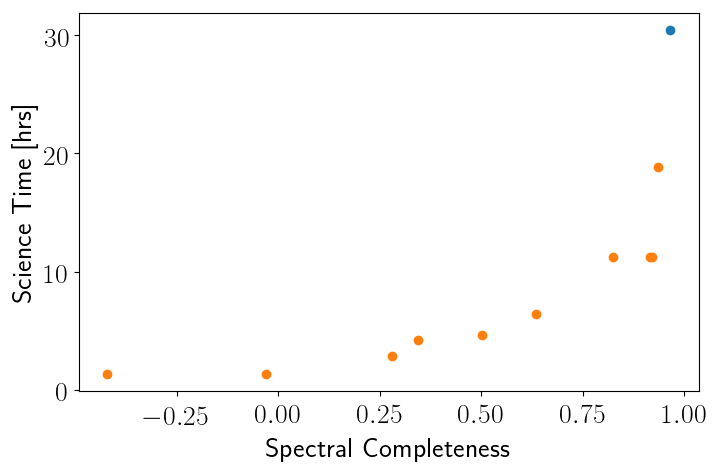

In [371]:
i = 1

fig, ax = plt.subplots()
ax.set_xlabel("Spectral Completeness")
ax.set_ylabel("Science Time [hrs]")
ax.plot(completeness[i], apply_two_channels(calc_t_chan(tpbpcs[i])), "o", c = "C0")

N = 10
new_tpbpc = copy.deepcopy(tpbpcs[i])
modtime = 0.0
modcomp = 0.0
for i in range(N):
    new_tpbpc, dt, dc, maxderiv = remove_worst_bandpass(new_tpbpc, specs[i])
    modcomp += dc
    
    ax.plot(completeness[i] - modcomp, apply_two_channels(calc_t_chan(new_tpbpc)), "o", c = "C1")

Text(0,0.5,'Exposure Time [hrs]')

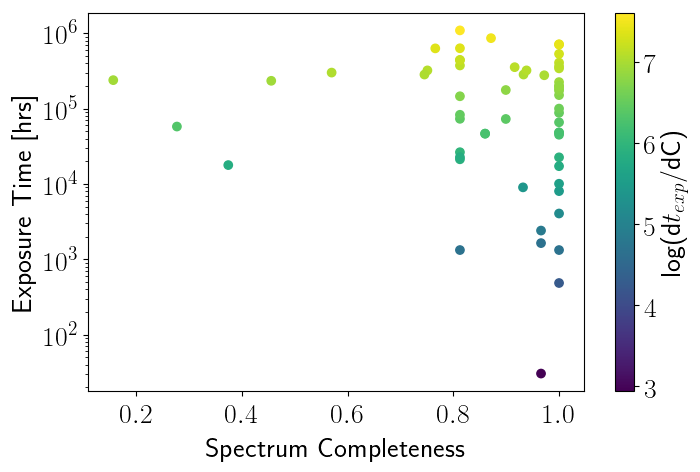

In [73]:
cvals = np.log10(maxderivs); clabel = "log(d$t_{exp}$/dC)"

fig, ax = plt.subplots()
s = ax.scatter(completeness, t_tots, marker = "o", c = cvals)
#plt.plot(new_completeness, new_t_tots, "o")
ax.set_yscale("log")
plt.colorbar(s, label = clabel)
ax.set_xlabel("Spectrum Completeness")
ax.set_ylabel("Exposure Time [hrs]")

In [387]:
modcomps_N = np.zeros((N, len(dist)))

In [398]:
N = 3

tpbpcs_N = [tpbpcs]
modcomps_N = np.zeros((N+1, len(dist)))
completeness_N = np.zeros((N+1, len(dist)))
t_tots_N = np.zeros((N+1, len(dist)))

modcomps_N[0,:]
completeness_N[0,:] = completeness
t_tots_N[0,:] = t_tots

for i in range(N):
    tmpt = []
    tmpc = []
    for j in range(len(dist)):
        new_tpbpc, modtime, modcomp, maxderiv = remove_worst_bandpass(tpbpcs_N[-1][j], specs[j])
        tmpt.append(new_tpbpc)
        modcomps_N[i+1,j] = modcomp
        completeness_N[i+1,j] = completeness[j] - np.sum(modcomps_N[:,j])
        t_tots_N[i+1,j] = apply_two_channels(calc_t_chan(new_tpbpc))
    tpbpcs_N.append(tmpt)

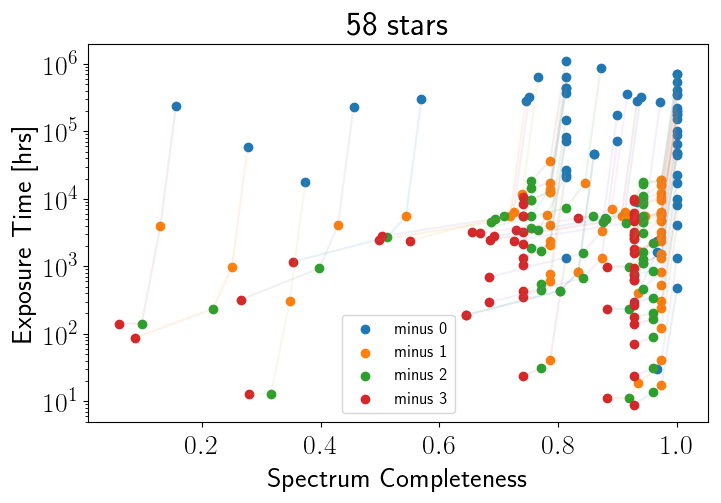

In [404]:
fig, ax = plt.subplots()

for i in range(N+1):
    s = ax.scatter(completeness_N[i,:], t_tots_N[i,:], marker = "o", label = "minus %i" %(i))

for i in range(len(dist)):
    ax.plot(completeness_N[:,i], t_tots_N[:,i], alpha = 0.1)
    
ax.set_yscale("log")
ax.set_title("%i stars" %len(dist))
#plt.colorbar(s, label = clabel)
ax.set_xlabel("Spectrum Completeness")
ax.set_ylabel("Exposure Time [hrs]")
ax.legend(fontsize = 12)

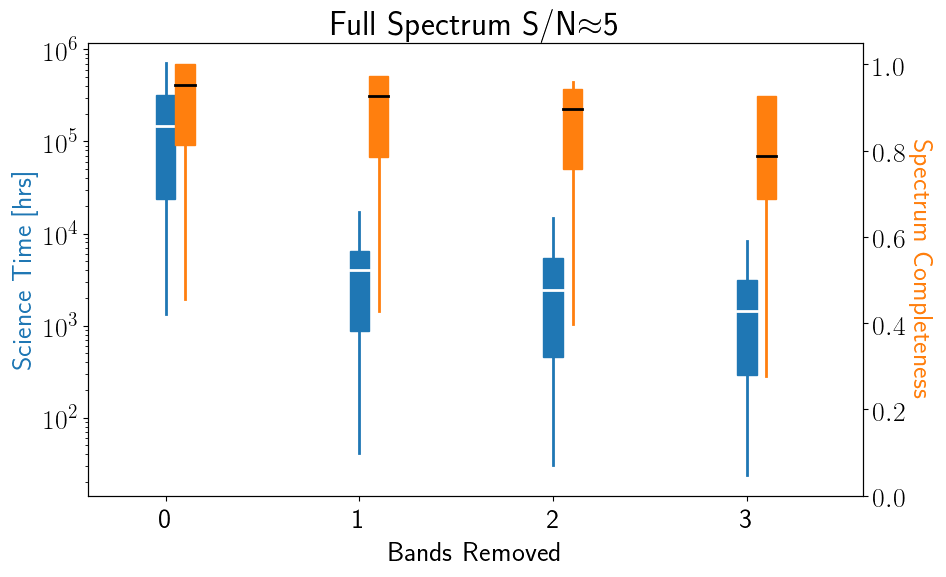

In [481]:
fig2, ax2 = plt.subplots(figsize = (10,6))
ax3 = ax2.twinx()
    
data = [t_tots_N[i,:] for i in range(N+1)]
color1 = "C0"
positions = np.arange(N+1)
bp1 = ax2.boxplot(data, sym = '', widths = 0.1, showfliers = False, boxprops = {"color" :color1}, 
                 whiskerprops = {"color" : color1, "linewidth" : 2.0}, capprops = {"color" : color1, "linewidth" : 0.0}, medianprops = {"color" : "w", "linewidth" : 2.0}, 
                 patch_artist=True, positions = positions, whis = [5, 95]); 

data = [completeness_N[i,:] for i in range(N+1)]
color2 = "C1"
positions = np.arange(N+1) + 0.1
bp2 = ax3.boxplot(data, sym = '', widths = 0.1, showfliers = False, boxprops = {"color" : color2}, 
                 whiskerprops = {"color" : color2, "linewidth" : 2.0}, capprops = {"color" : color2, "linewidth" : 0.0}, medianprops = {"color" : "k", "linewidth" : 2.0}, 
                 patch_artist=True, positions = positions, whis = [5, 95]); 

for patch in bp1['boxes']:
    patch.set_facecolor(color1)
for patch in bp2['boxes']:
    patch.set_facecolor(color2)
    
ax2.set_ylabel("Science Time [hrs]", color = color1)
ax2.set_title(r"Full Spectrum S/N$\approx$%i" %wantSNR)
ax2.set_yscale("log")

ax2.set_xlabel("Bands Removed")
ax3.set_ylabel("Spectrum Completeness", rotation = 270, labelpad = 22, color = color2)
ax3.set_ylim(0.0,1.05)

ax2.set_xticks(np.arange(N+1));
ax2.set_xticklabels(np.arange(N+1));

In [428]:
tmp = [np.zeros((len(tpbpcs[0][i]), len(tpbpcs))) for i in range(len(tpbpcs[0]))]

for i in range(len(tpbpcs)):
    for j in range(len(tpbpcs[0])):
        tmp[j][:,i] = tpbpcs[i][j]

In [454]:
#spectrum = (np.array(full_lam), np.array(full_Cratio), np.array(full_Cobs), np.array(full_Csig))

In [459]:
specs[0][1][0]

array([1.38296867e-12, 7.74974974e-13, 1.98624651e-13])

(0.1, 2.0)

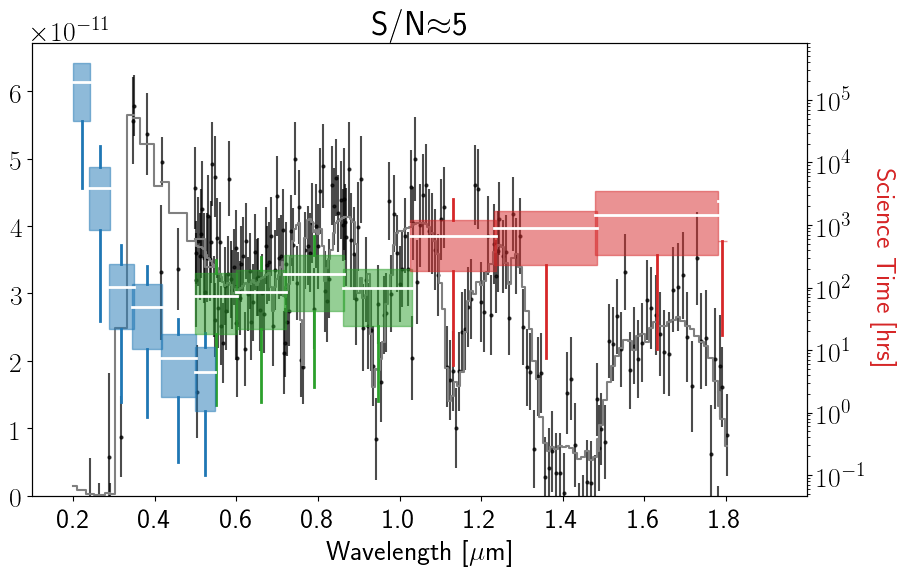

In [479]:
fig, ax = plt.subplots(figsize = (10,6))
cc = ["C0", "C2", "C3"]

ax2 = ax.twinx()

#ax.plot(lamhr, Ahr, c = "k", zorder = 100)
#ax.set_ylim(0.0, 0.1*np.ceil(10*np.max(Ahr[lamhr < 2.0])))
#ax.set_ylabel("Geometric Albedo")

icount = 0
for j in range(len(tmp)):
    
    data = []
    positions = []
    widths = []
    for i in range(tmp[j].shape[0]):
        data.append(tmp[j][i,:])
        positions.append(np.mean(specs[0][0][icount]))
        widths.append(specs[0][0][icount][-1] - specs[0][0][icount][0])
        
        ax.plot(specs[0][0][icount], specs[0][1][icount], ls = "steps-mid", color = "grey", zorder = 100)
        ax.errorbar(specs[0][0][icount], specs[0][2][icount], yerr=specs[0][3][icount], fmt = "o", ms = 2.0, alpha = 0.7, color = "k")
        
        icount += 1
        
    color1 = cc[j]
    positions = np.array(positions)
    widths = np.array(widths)
    bp1 = ax2.boxplot(data, sym = '', widths = widths, showfliers = False, boxprops = {"color" : color1, "alpha" : 0.5}, 
                     whiskerprops = {"color" : color1, "linewidth" : 2.0}, capprops = {"color" : color1, "linewidth" : 0.0}, medianprops = {"color" : "w", "linewidth" : 2.0}, 
                     patch_artist=True, positions = positions, whis = [5, 95]); 

    for patch in bp1['boxes']:
        patch.set_facecolor(color1)
    
ax2.set_ylabel("Science Time [hrs]", color = color1, rotation = 270, labelpad = 22)
ax2.set_title(r"S/N$\approx$%i" %wantSNR)
ax2.set_yscale("log")

ax.set_xlabel("Wavelength [$\mu$m]")
ax.set_ylim(bottom = 0.0)

ax2.set_xticks([0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8])
ax2.set_xticklabels([0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8])
ax2.set_xlim(0.1, 2.0)

## Draw stellar samples from precomputed exopsure times

In [521]:
Xdraw = 500    # Number for unbiased random samples
Ndraw = 5      # Number of stars to randomly draw from biased sample
Nrem = 2

np.random.seed(seed=None)

# Get index with matching stellar type in stellar properties table
imatches = np.array([match_stellar_type(stype[j], verbose = False) for j in range(len(stype))])

# Allocate memory for exposure times
ctime_tot = np.zeros((Ndraw, Xdraw))
ccomp_tot = np.zeros((Ndraw, Xdraw))

# Loop over number of random draws (for bootstrapping distributions)
for ix in range(Xdraw):
    
    # Randomly draw sample indices
    idraw = np.random.choice(np.arange(len(hip)), size=Ndraw, replace=False)
    
    # Order systems by "detectability" (sorting must happen at a later step)
    #idraw = idraw[np.argsort(dist[idraw])]   # Simply distance for now
    
    # Get the total exposure time and completeness for the selected stars
    ctime_tmp = t_tots_N[Nrem, idraw]
    ccomp_tmp = completeness_N[Nrem, idraw]
    
    # Sort by exposure time (to break a labeling degeneracy and express uniqueness and priority)
    isort = np.argsort(ctime_tmp)
    
    # Set exposure time for this star
    ctime_tot[:, ix] = ctime_tmp[isort]

    # Set completeness for this star
    ccomp_tot[:, ix] = ccomp_tmp[isort]

    # Replaced loop with more efficient masking approach
    """
    # Loop over stars in this sample
    for i, j in enumerate(idraw):
        
        # Get index with matching stellar type in stellar properties table
        imatch = imatches[j]
        
        # Get exposure time for this star
        ctime_tot[i, ix] = t_tots[j]
        
        # Get completeness for this star
        ccomp_tot[i, ix] = completeness[j]
    """

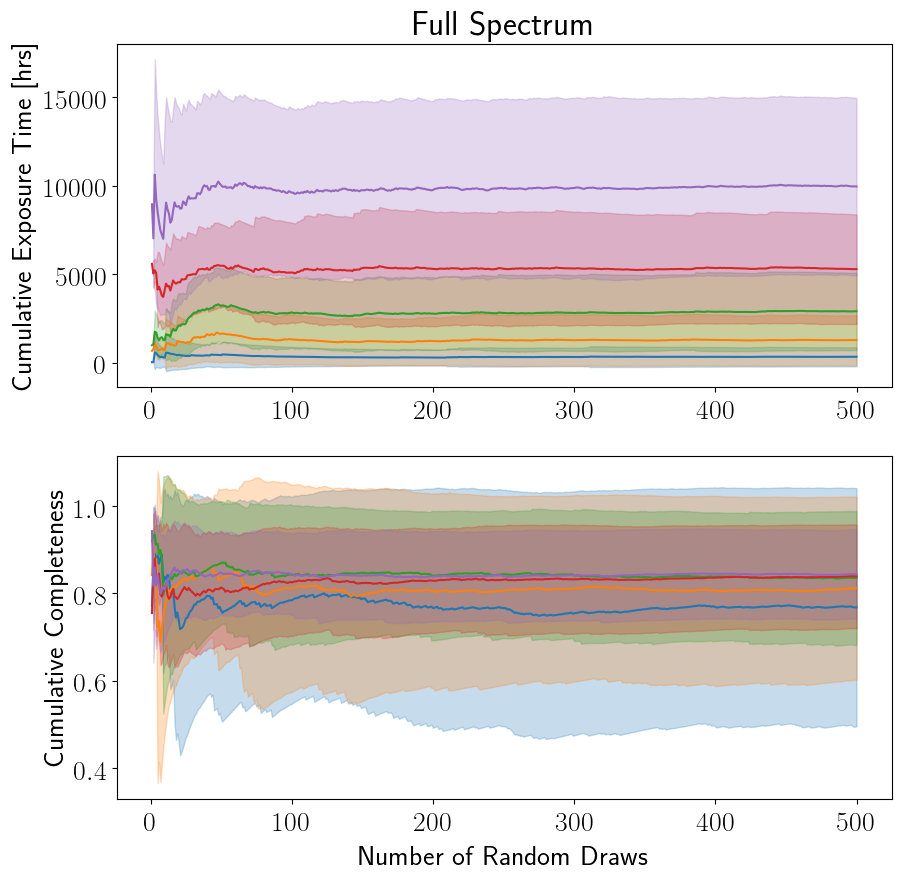

In [522]:
fig, ax = plt.subplots(2, 1, figsize = (10,10))

# Loop over stars in sample
for i in range(Ndraw):
    
    # Calculate the cumulative mean time (to estimate convergence)
    cummean_time = pd.Series(ctime_tot[i,:]).expanding(1).mean().values
    # Calculate the cumulative std deviation 
    cumstd_time = pd.Series(ctime_tot[i,:]).expanding(1).std().values
    
    # Calculate the cumulative mean completeness (to estimate convergence)
    cummean_comp = pd.Series(ccomp_tot[i,:]).expanding(1).mean().values
    # Calculate the cumulative std deviation 
    cumstd_comp = pd.Series(ccomp_tot[i,:]).expanding(1).std().values
    
    # Plot time
    ax[0].plot((np.arange(Xdraw)+1), cummean_time, c = "C%i" %(i%9))
    #ax.errorbar(np.arange(Xdraw)+1, cummean, yerr=cumstd)
    ax[0].fill_between(np.arange(Xdraw)+1, cummean_time - cumstd_time, cummean_time + cumstd_time, alpha = 0.25, color = "C%i" %(i%9))
    ax[0].set_ylabel("Cumulative Exposure Time [hrs]")
    ax[0].set_title("Full Spectrum")
    
     # Plot completeness
    ax[1].plot((np.arange(Xdraw)+1), cummean_comp, c = "C%i" %(i%9))
    #ax.errorbar(np.arange(Xdraw)+1, cummean, yerr=cumstd)
    ax[1].fill_between(np.arange(Xdraw)+1, cummean_comp - cumstd_comp, cummean_comp + cumstd_comp, alpha = 0.25, color = "C%i" %(i%9))
    ax[1].set_xlabel("Number of Random Draws")
    ax[1].set_ylabel("Cumulative Completeness")

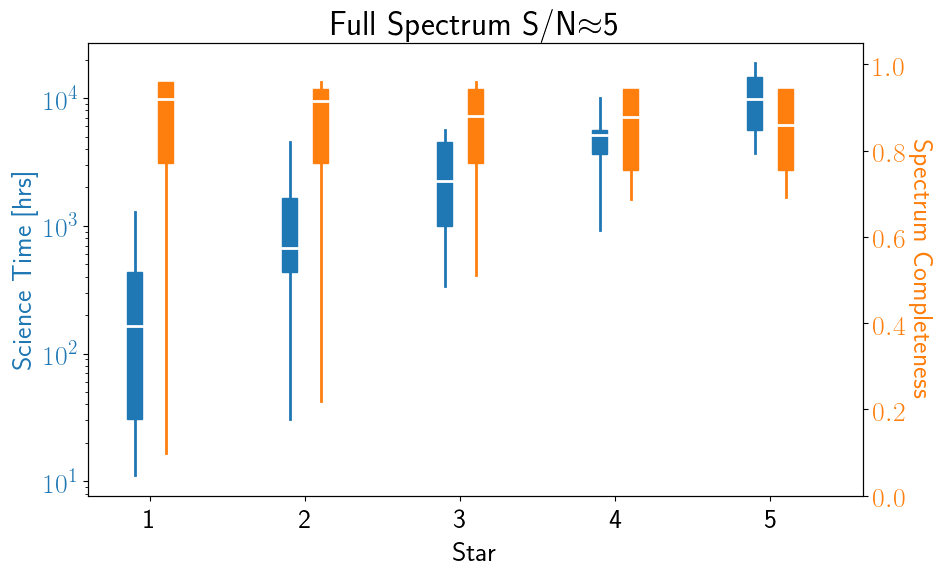

In [527]:
fig2, ax2 = plt.subplots(figsize = (10,6))
ax3 = ax2.twinx()

# Loop over stars in sample
for i in range(Ndraw):

    # Plot time intervals
    #q_l, q_50, q_h, q_m, q_p = nsig_intervals(ctime_tot[i,:], intvls=[0.16, 0.5, 0.84])
    #ax2.errorbar(i+1, q_50, yerr = np.array([q_m, q_p]).reshape((2,1)), fmt = "o", color = "C0")
    
    # Plot completeness intervals
    #q_l, q_50, q_h, q_m, q_p = nsig_intervals(ccomp_tot[i,:], intvls=[0.16, 0.5, 0.84])
    #ax3.errorbar(i+1.05, q_50, yerr = np.array([q_m, q_p]).reshape((2,1)), fmt = "x", color = "C1")
    #ax2[1].set_yscale("log")
    pass
    
data = [ctime_tot[i,:] for i in range(Ndraw)]
color1 = "C0"
positions = np.arange(Ndraw) + 0.9
bp1 = ax2.boxplot(data, sym = '', widths = 0.1, showfliers = False, boxprops = {"color" :color1}, 
                 whiskerprops = {"color" : color1, "linewidth" : 2.0}, capprops = {"color" : color1, "linewidth" : 0.0}, medianprops = {"color" : "w", "linewidth" : 2.0}, 
                 patch_artist=True, positions = positions, whis = [5, 95]); 

data = [ccomp_tot[i,:] for i in range(Ndraw)]
color2 = "C1"
positions = np.arange(Ndraw) + 1.1
bp2 = ax3.boxplot(data, sym = '', widths = 0.1, showfliers = False, boxprops = {"color" : color2}, 
                 whiskerprops = {"color" : color2, "linewidth" : 2.0}, capprops = {"color" : color2, "linewidth" : 0.0}, medianprops = {"color" : "w", "linewidth" : 2.0}, 
                 patch_artist=True, positions = positions, whis = [5, 95]); 

for patch in bp1['boxes']:
    patch.set_facecolor(color1)
for patch in bp2['boxes']:
    patch.set_facecolor(color2)
    
_ = [i.set_color(color1) for i in ax2.get_yticklabels()];
_ = [i.set_color(color2) for i in ax3.get_yticklabels()];
    
ax2.set_ylabel("Science Time [hrs]", color = color1)
ax2.set_title(r"Full Spectrum S/N$\approx$%i" %wantSNR)
ax2.set_yscale("log")

ax2.set_xlabel("Star")
ax3.set_ylabel("Spectrum Completeness", rotation = 270, labelpad = 22, color = color2)
ax3.set_ylim(0.0,1.05)

ax2.set_xticks(np.arange(Ndraw)+1);
ax2.set_xticklabels(np.arange(Ndraw)+1);

In [81]:
Xdraw = 500    # Number for unbiased random samples
Ndraw = 5      # Number of stars to randomly draw from biased sample

np.random.seed(seed=None)

# Get index with matching stellar type in stellar properties table
imatches = np.array([match_stellar_type(stype[j], verbose = False) for j in range(len(stype))])

# Allocate memory for exposure times
ctime_tot = np.zeros((Ndraw, Xdraw))
ccomp_tot = np.zeros((Ndraw, Xdraw))

# Loop over number of random draws (for bootstrapping distributions)
for ix in range(Xdraw):
    
    # Randomly draw sample indices
    idraw = np.random.choice(np.arange(len(hip)), size=Ndraw, replace=False)
    
    # Order systems by "detectability"
    idraw = idraw[np.argsort(dist[idraw])]   # Simply distance for now
    
    # Loop over stars in this sample
    for i, j in enumerate(idraw):
        
        # Get index with matching stellar type in stellar properties table
        imatch = imatches[j]
        
        # Get exposure time for this star
        ctime_tot[i, ix] = new_t_tots[j]
        
        # Get completeness for this star
        ccomp_tot[i, ix] = new_completeness[j]

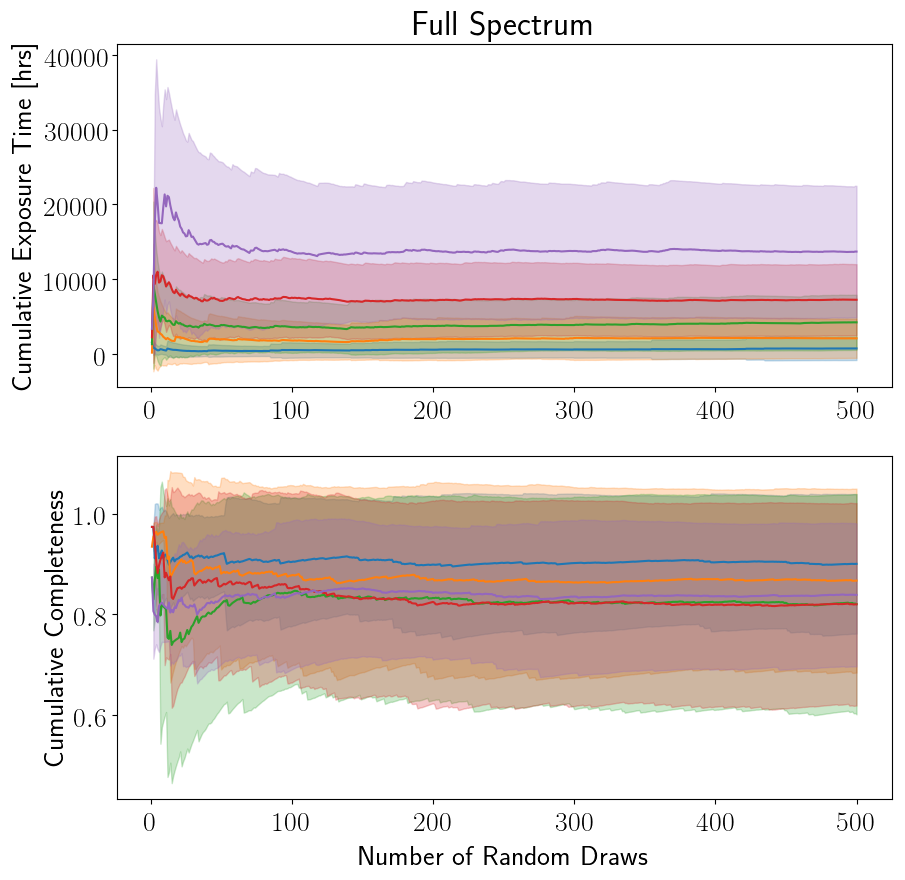

In [82]:
fig, ax = plt.subplots(2, 1, figsize = (10,10))

# Loop over stars in sample
for i in range(Ndraw):
    
    # Calculate the cumulative mean time (to estimate convergence)
    cummean_time = pd.Series(ctime_tot[i,:]).expanding(1).mean().values
    # Calculate the cumulative std deviation 
    cumstd_time = pd.Series(ctime_tot[i,:]).expanding(1).std().values
    
    # Calculate the cumulative mean completeness (to estimate convergence)
    cummean_comp = pd.Series(ccomp_tot[i,:]).expanding(1).mean().values
    # Calculate the cumulative std deviation 
    cumstd_comp = pd.Series(ccomp_tot[i,:]).expanding(1).std().values
    
    # Plot time
    ax[0].plot((np.arange(Xdraw)+1), cummean_time, c = "C%i" %i)
    #ax.errorbar(np.arange(Xdraw)+1, cummean, yerr=cumstd)
    ax[0].fill_between(np.arange(Xdraw)+1, cummean_time - cumstd_time, cummean_time + cumstd_time, alpha = 0.25, color = "C%i" %i)
    ax[0].set_ylabel("Cumulative Exposure Time [hrs]")
    ax[0].set_title("Full Spectrum")
    
     # Plot completeness
    ax[1].plot((np.arange(Xdraw)+1), cummean_comp, c = "C%i" %i)
    #ax.errorbar(np.arange(Xdraw)+1, cummean, yerr=cumstd)
    ax[1].fill_between(np.arange(Xdraw)+1, cummean_comp - cumstd_comp, cummean_comp + cumstd_comp, alpha = 0.25, color = "C%i" %i)
    ax[1].set_xlabel("Number of Random Draws")
    ax[1].set_ylabel("Cumulative Completeness")

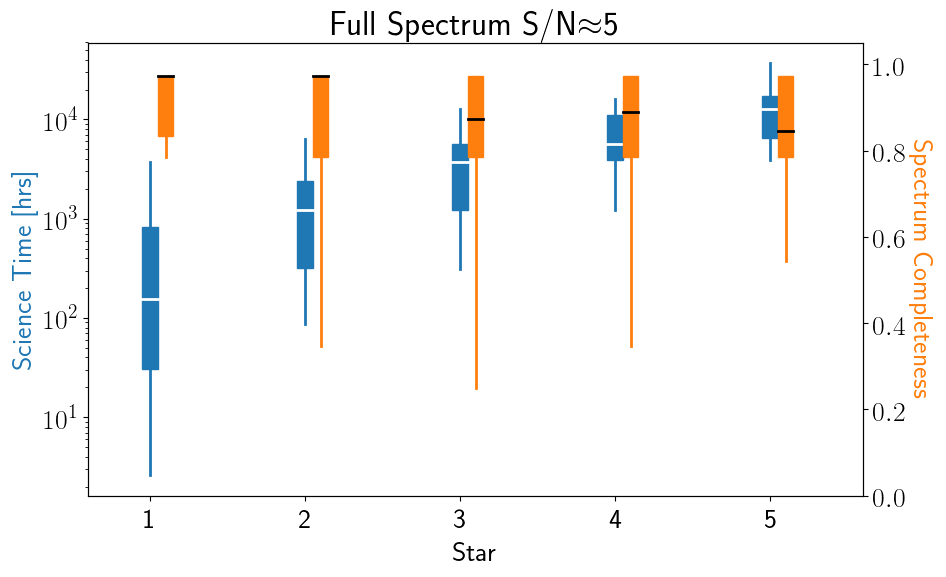

In [83]:
fig2, ax2 = plt.subplots(figsize = (10,6))
ax3 = ax2.twinx()

# Loop over stars in sample
for i in range(Ndraw):

    # Plot time intervals
    #q_l, q_50, q_h, q_m, q_p = nsig_intervals(ctime_tot[i,:], intvls=[0.16, 0.5, 0.84])
    #ax2.errorbar(i+1, q_50, yerr = np.array([q_m, q_p]).reshape((2,1)), fmt = "o", color = "C0")
    
    # Plot completeness intervals
    #q_l, q_50, q_h, q_m, q_p = nsig_intervals(ccomp_tot[i,:], intvls=[0.16, 0.5, 0.84])
    #ax3.errorbar(i+1.05, q_50, yerr = np.array([q_m, q_p]).reshape((2,1)), fmt = "x", color = "C1")
    #ax2[1].set_yscale("log")
    pass
    
data = [ctime_tot[i,:] for i in range(Ndraw)]
color1 = "C0"
positions = np.arange(Ndraw) + 1
bp1 = ax2.boxplot(data, sym = '', widths = 0.1, showfliers = False, boxprops = {"color" :color1}, 
                 whiskerprops = {"color" : color1, "linewidth" : 2.0}, capprops = {"color" : color1, "linewidth" : 0.0}, medianprops = {"color" : "w", "linewidth" : 2.0}, 
                 patch_artist=True, positions = positions, whis = [5, 95]); 

data = [ccomp_tot[i,:] for i in range(Ndraw)]
color2 = "C1"
positions = np.arange(Ndraw) + 1.1
bp2 = ax3.boxplot(data, sym = '', widths = 0.1, showfliers = False, boxprops = {"color" : color2}, 
                 whiskerprops = {"color" : color2, "linewidth" : 2.0}, capprops = {"color" : color2, "linewidth" : 0.0}, medianprops = {"color" : "k", "linewidth" : 2.0}, 
                 patch_artist=True, positions = positions, whis = [5, 95]); 

for patch in bp1['boxes']:
    patch.set_facecolor(color1)
for patch in bp2['boxes']:
    patch.set_facecolor(color2)
    
ax2.set_ylabel("Science Time [hrs]", color = color1)
ax2.set_title(r"Full Spectrum S/N$\approx$%i" %wantSNR)
ax2.set_yscale("log")

ax2.set_xlabel("Star")
ax3.set_ylabel("Spectrum Completeness", rotation = 270, labelpad = 22, color = color2)
ax3.set_ylim(0.0,1.05)

ax2.set_xticks(np.arange(Ndraw)+1);
ax2.set_xticklabels(np.arange(Ndraw)+1);